In [0]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession,SQLContext

from pyspark.sql.types import *
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import udf,col


In [0]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
#inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1.The Data Set:

![class_diagram_retail](files/tables/cloudera_retail_db.png)

### 2. Creating the Spark Session:

In [0]:
spark = (SparkSession
        .builder
        .master('local[*]')
        .appName('PySpark-Reatail-DB-Analysis')
        .getOrCreate())

In [0]:
spark

In [0]:
sqlContext = SQLContext(spark.sparkContext)

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
sqlContext

### 3.Loading the Data From Files Into DataFrames:

In [0]:
customer_data =   'dbfs:/FileStore/tables/customers.csv'
department_data = 'dbfs:/FileStore/tables/departments.csv'
categories_data =  'dbfs:/FileStore/tables/categories.csv'
products_data =    'dbfs:/FileStore/tables/products.csv'
orders_data =      'dbfs:/FileStore/tables/orders.csv'
order_items_data = 'dbfs:/FileStore/tables/order_items.csv'

In [0]:
#declaring the schema
customer_schema = StructType([
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('first_name', StringType(), nullable=True),
    StructField('last_name', StringType(), nullable=True),
    StructField('email', StringType(), nullable=True),
    StructField('password', StringType(), nullable=True),
    StructField('street', StringType(), nullable=True),
    StructField('city', StringType(), nullable=True),
    StructField('state', StringType(), nullable=True),
    StructField('zipcode', StringType(), nullable=True), 
    
])

In [0]:
department_schema = StructType([
    StructField('department_id', IntegerType(), nullable=True),
    StructField('department_name', StringType(), nullable=True),
])

In [0]:
categories_schema = StructType([
    StructField('category_id',            IntegerType(), nullable=True),
    StructField('category_department_id', IntegerType(), nullable=True),
    StructField('category_name',          StringType(), nullable=True)
])

In [0]:
products_schema = StructType([
    StructField('product_id',          IntegerType(), nullable=True),
    StructField('product_category_id', IntegerType(), nullable=True),
    StructField('product_name',        StringType(), nullable=True),
    StructField('description', StringType(), nullable=True),
    StructField('price',       FloatType(), nullable=True),
    StructField('image',       StringType(), nullable=True)
])

In [0]:
orders_schema = StructType([
    StructField('order_id',          IntegerType(), nullable=True),
    StructField('order_date',        StringType(), nullable=True),
    StructField('order_customer_id', IntegerType(), nullable=True),
    StructField('order_status',      StringType(), nullable=True)
])

In [0]:
order_items_schema = StructType([
    StructField('order_item_id',            IntegerType(), nullable=True),
    StructField('order_item_order_id',      IntegerType(), nullable=True),
    StructField('order_item_product_id',    IntegerType(), nullable=True),
    StructField('order_item_quantity',      IntegerType(), nullable=True),
    StructField('order_item_subtotal',      FloatType(), nullable=True),
    StructField('order_item_product_price', FloatType(), nullable=True)
])

In [0]:
customer_df = spark.read.csv(path=customer_data, schema=customer_schema)
customer_df.cache()

department_df = spark.read.csv(path=department_data, schema=department_schema)
department_df.cache()

category_df = spark.read.csv(path=categories_data, schema=categories_schema)
category_df.cache()

product_df = spark.read.csv(path=products_data, schema=products_schema)
product_df.cache()

order_df = spark.read.csv(path=orders_data, schema=orders_schema)
order_df.cache()

order_item_df = spark.read.csv(path=order_items_data, schema=order_items_schema)
order_item_df.cache()


DataFrame[order_item_id: int, order_item_order_id: int, order_item_product_id: int, order_item_quantity: int, order_item_subtotal: float, order_item_product_price: float]

### 3.1. Register DataFrames as Temporary Views for SPARK SQL:

In [0]:
customer_df.createOrReplaceTempView("customers")


In [0]:
customer_df.select([col(ch)  for ch in np.random.choice(customer_df.columns, size=5, replace=False)]).show(20)

+-----+-------+-------------+-----------+---------+
|state|zipcode|         city|customer_id| password|
+-----+-------+-------------+-----------+---------+
|   TX|  78521|  Brownsville|          1|XXXXXXXXX|
|   CO|  80126|    Littleton|          2|XXXXXXXXX|
|   PR|  00725|       Caguas|          3|XXXXXXXXX|
|   CA|  92069|   San Marcos|          4|XXXXXXXXX|
|   PR|  00725|       Caguas|          5|XXXXXXXXX|
|   NJ|  07055|      Passaic|          6|XXXXXXXXX|
|   PR|  00725|       Caguas|          7|XXXXXXXXX|
|   MA|  01841|     Lawrence|          8|XXXXXXXXX|
|   PR|  00725|       Caguas|          9|XXXXXXXXX|
|   VA|  22554|     Stafford|         10|XXXXXXXXX|
|   PR|  00725|       Caguas|         11|XXXXXXXXX|
|   TX|  78227|  San Antonio|         12|XXXXXXXXX|
|   PR|  00725|       Caguas|         13|XXXXXXXXX|
|   CA|  90660|  Pico Rivera|         14|XXXXXXXXX|
|   CA|  92336|      Fontana|         15|XXXXXXXXX|
|   PR|  00725|       Caguas|         16|XXXXXXXXX|
|   MI|  481

In [0]:
department_df.createOrReplaceTempView("departments")

In [0]:
department_df.show(10)

+-------------+---------------+
|department_id|department_name|
+-------------+---------------+
|            2|        Fitness|
|            3|       Footwear|
|            4|        Apparel|
|            5|           Golf|
|            6|       Outdoors|
|            7|       Fan Shop|
+-------------+---------------+



In [0]:
category_df.createOrReplaceTempView("categories")

In [0]:
category_df.show(10)

+-----------+----------------------+-------------------+
|category_id|category_department_id|      category_name|
+-----------+----------------------+-------------------+
|          1|                     2|           Football|
|          2|                     2|             Soccer|
|          3|                     2|Baseball & Softball|
|          4|                     2|         Basketball|
|          5|                     2|           Lacrosse|
|          6|                     2|   Tennis & Racquet|
|          7|                     2|             Hockey|
|          8|                     2|        More Sports|
|          9|                     3|   Cardio Equipment|
|         10|                     3|  Strength Training|
+-----------+----------------------+-------------------+
only showing top 10 rows



In [0]:
product_df.createOrReplaceTempView("products")

In [0]:
product_df.show(10)

+----------+-------------------+--------------------+-----------+------+--------------------+
|product_id|product_category_id|        product_name|description| price|               image|
+----------+-------------------+--------------------+-----------+------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|       null| 59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|       null|129.99|http://images.acm...|
|         3|                  2|Under Armour Men'...|       null| 89.99|http://images.acm...|
|         4|                  2|Under Armour Men'...|       null| 89.99|http://images.acm...|
|         5|                  2|Riddell Youth Rev...|       null|199.99|http://images.acm...|
|         6|                  2|Jordan Men's VI R...|       null|134.99|http://images.acm...|
|         7|                  2|Schutt Youth Recr...|       null| 99.99|http://images.acm...|
|         8|                  2|Nike Men's Vapor ...|       

In [0]:
order_df.createOrReplaceTempView("orders")

In [0]:
order_df.show(10)

+--------+--------------------+-----------------+---------------+
|order_id|          order_date|order_customer_id|   order_status|
+--------+--------------------+-----------------+---------------+
|       1|2013-07-25 00:00:...|            11599|         CLOSED|
|       2|2013-07-25 00:00:...|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:...|            12111|       COMPLETE|
|       4|2013-07-25 00:00:...|             8827|         CLOSED|
|       5|2013-07-25 00:00:...|            11318|       COMPLETE|
|       6|2013-07-25 00:00:...|             7130|       COMPLETE|
|       7|2013-07-25 00:00:...|             4530|       COMPLETE|
|       8|2013-07-25 00:00:...|             2911|     PROCESSING|
|       9|2013-07-25 00:00:...|             5657|PENDING_PAYMENT|
|      10|2013-07-25 00:00:...|             5648|PENDING_PAYMENT|
+--------+--------------------+-----------------+---------------+
only showing top 10 rows



In [0]:
order_item_df.createOrReplaceTempView("order_items")

In [0]:
order_item_df.show(10)

+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|            1|                  1|                  957|                  1|             299.98|                  299.98|
|            2|                  2|                 1073|                  1|             199.99|                  199.99|
|            3|                  2|                  502|                  5|              250.0|                    50.0|
|            4|                  2|                  403|                  1|             129.99|                  129.99|
|            5|                  4|                  897|                  2|              49.98|                   24.99|
|            6| 

### 4. Data Analysis

#### 4.1 How Many Orders Were Placed:

##### Spark SQL

In [0]:

spark.sql("Select count(order_id) from orders").show()

+---------------+
|count(order_id)|
+---------------+
|          68883|
+---------------+



##### DF API:

In [0]:
order_df.count()

68883

### 4.2 Average Revenue Per Order:

###### Spark SQL

In [0]:
spark.sql('''SELECT ROUND(SUM(oi.order_item_subtotal)/COUNT(DISTINCT oi.order_item_order_id),2) AS avg_revenue_per_order 
          FROM orders o JOIN order_items oi
          ON o.order_id = oi.order_item_order_id''').show()

+---------------------+
|avg_revenue_per_order|
+---------------------+
|               597.63|
+---------------------+



##### DF API

In [0]:
### join two dataframes without duplicate column
(order_df.join(order_item_df, order_df.order_id == order_item_df.order_item_order_id)
         .select(['order_item_subtotal','order_item_order_id'])
         .select((F.round(F.sum('order_item_subtotal')/F.countDistinct('order_item_order_id'),2)).alias('avg_revenue_per_order'))
         .show()
         )

+---------------------+
|avg_revenue_per_order|
+---------------------+
|               597.63|
+---------------------+



### 4.3 Get Average Revenue Per Day:

##### SPARK SQL

In [0]:
### Using date function to show only date
spark.sql('''
            SELECT DATE(o.order_date) AS order_date, ROUND(SUM(oi.order_item_subtotal)/COUNT(DISTINCT oi.order_item_order_id), 2) as avg_rev_per_day
            FROM orders o JOIN order_items oi 
            ON o.order_id = oi.order_item_order_id
            GROUP BY order_date
            ORDER BY order_date          
''').show(truncate=False)

+----------+---------------+
|order_date|avg_rev_per_day|
+----------+---------------+
|2013-07-25|587.53         |
|2013-07-26|585.92         |
|2013-07-27|577.57         |
|2013-07-28|551.41         |
|2013-07-29|635.59         |
|2013-07-30|564.54         |
|2013-07-31|631.0          |
|2013-08-01|608.5          |
|2013-08-02|587.89         |
|2013-08-03|599.16         |
|2013-08-04|594.32         |
|2013-08-05|592.83         |
|2013-08-06|579.68         |
|2013-08-07|583.91         |
|2013-08-08|588.47         |
|2013-08-09|629.46         |
|2013-08-10|586.31         |
|2013-08-11|551.55         |
|2013-08-12|612.48         |
|2013-08-13|604.16         |
+----------+---------------+
only showing top 20 rows



#####  DF API

In [0]:
## Rounding the revenue with 2 decimal places
avg_rev_per_day = (order_df.join(order_item_df, order_df.order_id == order_item_df.order_item_order_id).select(['order_date', 'order_item_subtotal', 'order_item_order_id']).groupBy('order_date').agg((F.round(F.sum('order_item_subtotal') / F.countDistinct('order_item_order_id'),2)).alias('avg_rev_per_day'))   .orderBy('order_date'))
avg_rev_per_day.cache()

DataFrame[order_date: string, avg_rev_per_day: double]

In [0]:
avg_rev_per_day.show(truncate = False)

+---------------------+---------------+
|order_date           |avg_rev_per_day|
+---------------------+---------------+
|2013-07-25 00:00:00.0|587.53         |
|2013-07-26 00:00:00.0|585.92         |
|2013-07-27 00:00:00.0|577.57         |
|2013-07-28 00:00:00.0|551.41         |
|2013-07-29 00:00:00.0|635.59         |
|2013-07-30 00:00:00.0|564.54         |
|2013-07-31 00:00:00.0|631.0          |
|2013-08-01 00:00:00.0|608.5          |
|2013-08-02 00:00:00.0|587.89         |
|2013-08-03 00:00:00.0|599.16         |
|2013-08-04 00:00:00.0|594.32         |
|2013-08-05 00:00:00.0|592.83         |
|2013-08-06 00:00:00.0|579.68         |
|2013-08-07 00:00:00.0|583.91         |
|2013-08-08 00:00:00.0|588.47         |
|2013-08-09 00:00:00.0|629.46         |
|2013-08-10 00:00:00.0|586.31         |
|2013-08-11 00:00:00.0|551.55         |
|2013-08-12 00:00:00.0|612.48         |
|2013-08-13 00:00:00.0|604.16         |
+---------------------+---------------+
only showing top 20 rows



#### 4.3.1 Get Average Revenue Per Month:

##### DF API

In [0]:
avg_rev_per_month = (avg_rev_per_day
                     .select(F.month('order_date').alias('month'), 'avg_rev_per_day')
                     .groupBy('month')
                     .agg(F.round(F.avg('avg_rev_per_day'),2).alias('avg_rev_per_month'))
                     .orderBy('month'))

avg_rev_per_month.cache()


DataFrame[month: int, avg_rev_per_month: double]

In [0]:
avg_rev_per_month.show(truncate=False)

+-----+-----------------+
|month|avg_rev_per_month|
+-----+-----------------+
|1    |595.43           |
|2    |594.38           |
|3    |601.56           |
|4    |594.36           |
|5    |606.53           |
|6    |611.64           |
|7    |593.45           |
|8    |597.59           |
|9    |604.52           |
|10   |590.81           |
|11   |597.19           |
|12   |596.48           |
+-----+-----------------+



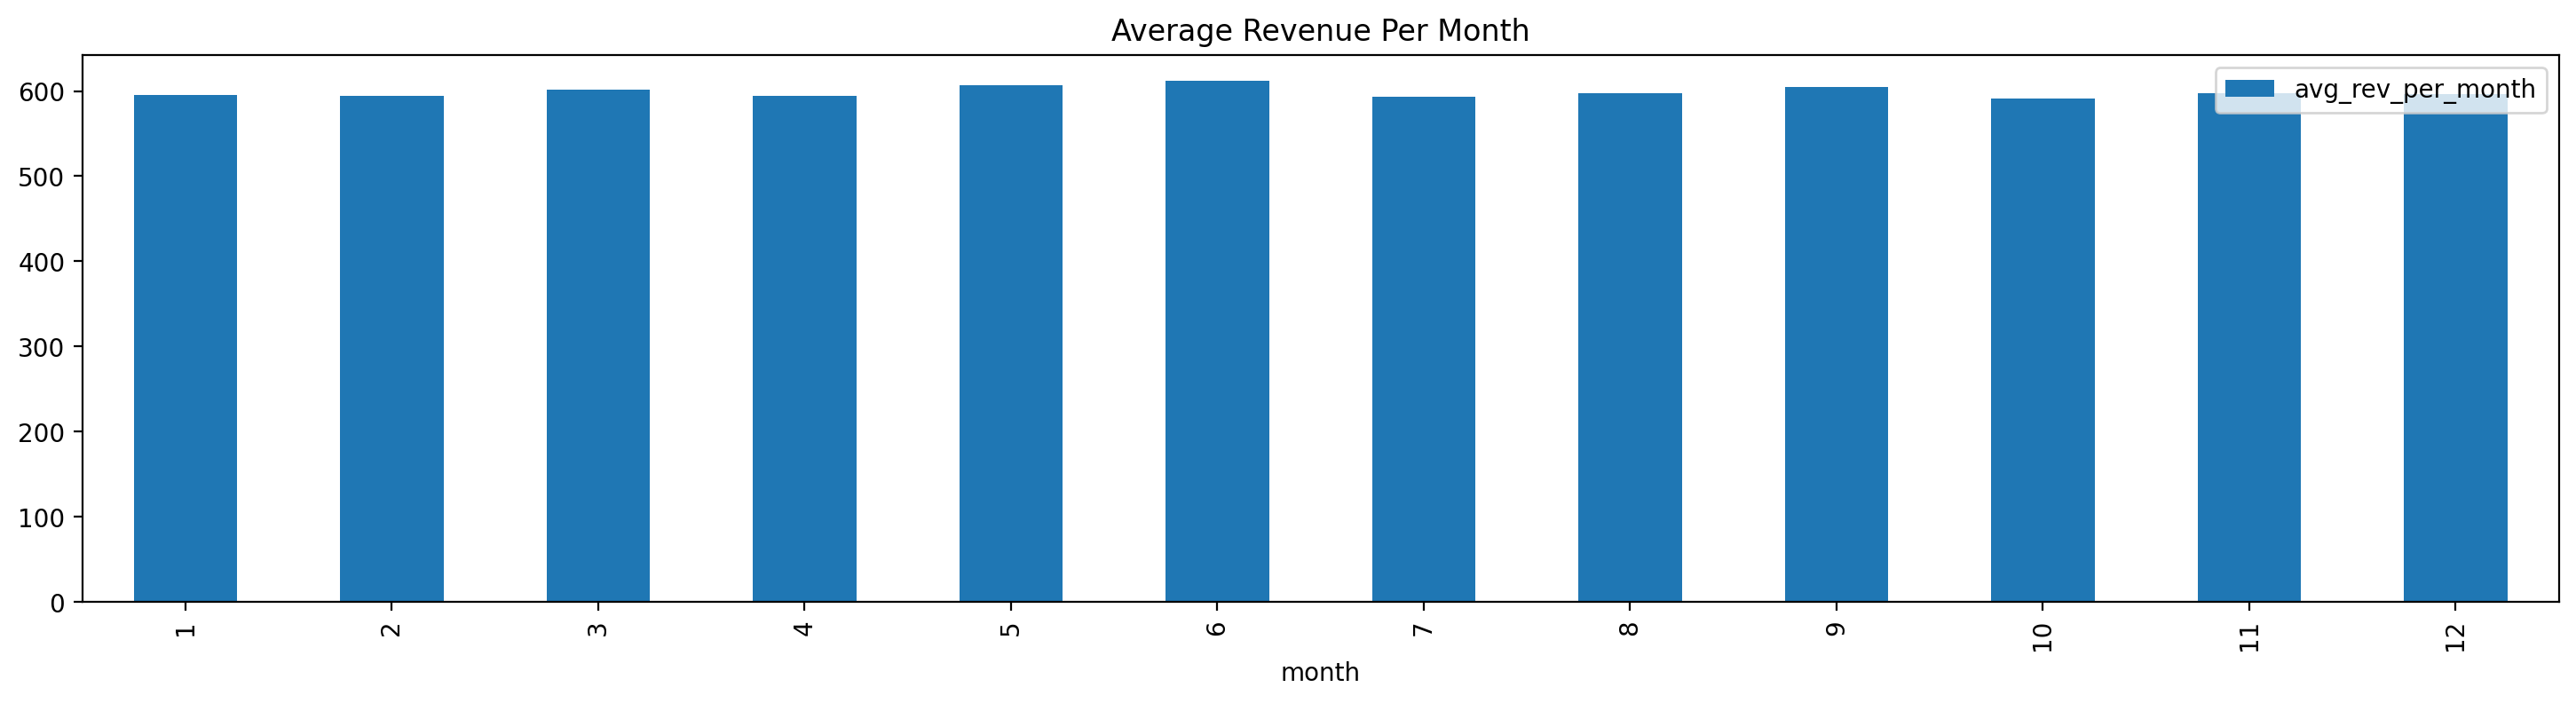

In [0]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

avg_rev_per_month.toPandas().plot.bar(x='month', title='Average Revenue Per Month');

In [0]:
avg_rev_per_month.unpersist()
avg_rev_per_day.unpersist()

DataFrame[order_date: string, avg_rev_per_day: double]

#### 4.3.2 Get Total Revenue Per Month Per Year:

##### SPARK SQL

In [0]:
spark.sql('''
             SELECT YEAR(o.order_date) as order_year,MONTH(o.order_date) as order_month,ROUND(SUM(oi.order_item_subtotal), 2) as total_revenue
             FROM orders o JOIN order_items oi
             ON o.order_id = oi.order_item_order_id
             GROUP BY order_year,order_month
             ORDER BY order_year,order_month
''').show(truncate=False)

+----------+-----------+-------------+
|order_year|order_month|total_revenue|
+----------+-----------+-------------+
|2013      |7          |764782.2     |
|2013      |8          |2828658.75   |
|2013      |9          |2934527.33   |
|2013      |10         |2624600.66   |
|2013      |11         |3168656.09   |
|2013      |12         |2932964.33   |
|2014      |1          |2924447.07   |
|2014      |2          |2778663.71   |
|2014      |3          |2862492.27   |
|2014      |4          |2807789.85   |
|2014      |5          |2753078.27   |
|2014      |6          |2703463.49   |
|2014      |7          |2238496.56   |
+----------+-----------+-------------+



##### DF API

In [0]:
total_rev_per_month_per_year = (order_df.join(order_item_df, order_df.order_id == order_item_df.order_item_order_id)
                                        .select([F.year('order_date').alias('order_year'), F.month('order_date').alias('order_month'), 'order_item_subtotal'])
                                        .groupBy(['order_year','order_month'])
                                        .agg(F.round(F.sum('order_item_subtotal'), 2).alias('total_revenue'))
                                        .orderBy(['order_year','order_month'])
                                        )

total_rev_per_month_per_year.cache()


DataFrame[order_year: int, order_month: int, total_revenue: double]

In [0]:
total_rev_per_month_per_year.show()

+----------+-----------+-------------+
|order_year|order_month|total_revenue|
+----------+-----------+-------------+
|      2013|          7|     764782.2|
|      2013|          8|   2828658.75|
|      2013|          9|   2934527.33|
|      2013|         10|   2624600.66|
|      2013|         11|   3168656.09|
|      2013|         12|   2932964.33|
|      2014|          1|   2924447.07|
|      2014|          2|   2778663.71|
|      2014|          3|   2862492.27|
|      2014|          4|   2807789.85|
|      2014|          5|   2753078.27|
|      2014|          6|   2703463.49|
|      2014|          7|   2238496.56|
+----------+-----------+-------------+



In [0]:
rev_plot = total_rev_per_month_per_year.toPandas()

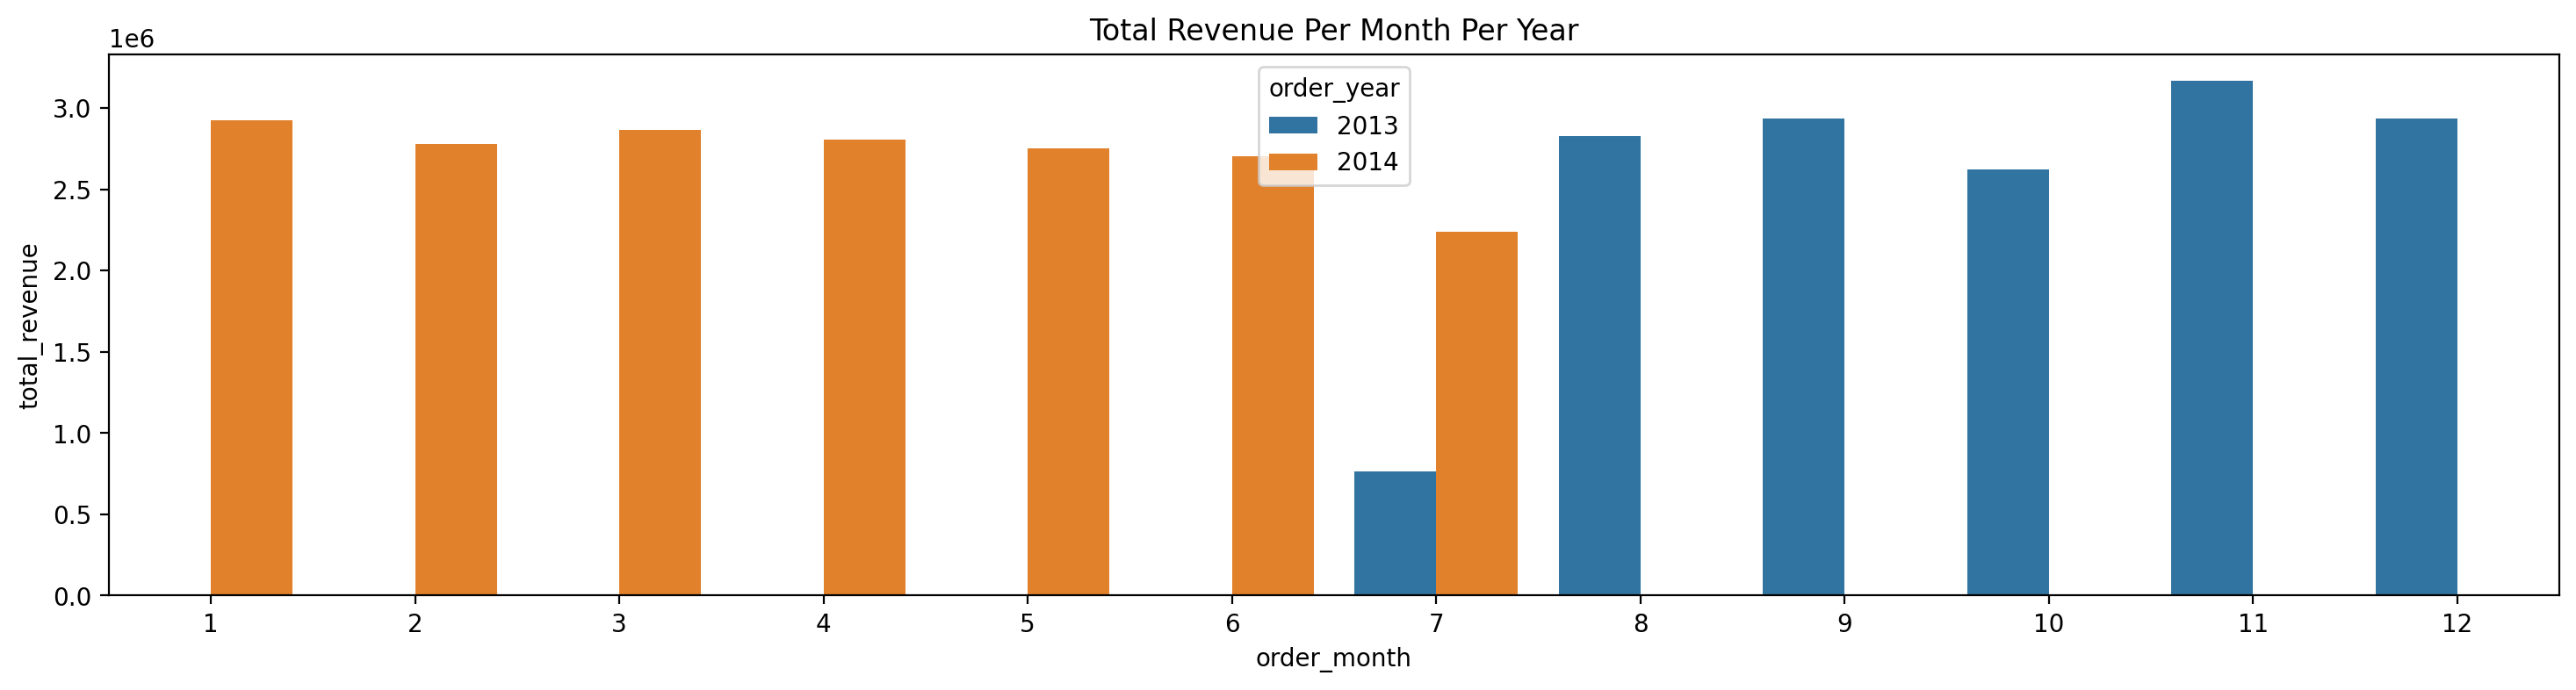

In [0]:
g = sns.barplot(x='order_month', y='total_revenue', hue='order_year', data=rev_plot)
g.set_title('Total Revenue Per Month Per Year');

In [0]:
total_rev_per_month_per_year.unpersist()

DataFrame[order_year: int, order_month: int, total_revenue: double]

### 4.4 Group Revenues per Month per Year:

##### SPARK SQL

In [0]:
### We are using Grouping_Sets - An aggregation across multiple groups which we cannot achieve using group by
## When we perform sum of revenues per month per year we can achieve the same using grouping sets as well besides the group by as shown below:


spark.sql('''
            SELECT YEAR(o.order_date) as order_year, MONTH(o.order_date) as order_month, ROUND(CAST(SUM(oi.order_item_subtotal) as decimal(38,2)), 2) as total_reveneue
            FROM orders o join order_items oi
            on o.order_id = oi.order_item_order_id
            group by order_year,order_month
            GROUPING SETS((order_year, order_month))
            order by order_year,order_month
            ''').show(50)

+----------+-----------+--------------+
|order_year|order_month|total_reveneue|
+----------+-----------+--------------+
|      2013|          7|     764782.20|
|      2013|          8|    2828658.75|
|      2013|          9|    2934527.33|
|      2013|         10|    2624600.66|
|      2013|         11|    3168656.09|
|      2013|         12|    2932964.33|
|      2014|          1|    2924447.07|
|      2014|          2|    2778663.71|
|      2014|          3|    2862492.27|
|      2014|          4|    2807789.85|
|      2014|          5|    2753078.27|
|      2014|          6|    2703463.49|
|      2014|          7|    2238496.56|
+----------+-----------+--------------+



In [0]:
## The same as above results for total_revenue considering order_year,order_month
### Another scenario to consider if we also want to include total revenue irrespective of the order_month and the order_year in the same result?
#### With a group-by statement, this would be impossible. But it’s simple with grouping sets: 
spark.sql('''
            SELECT YEAR(o.order_date) as order_year, MONTH(o.order_date) as order_month, ROUND(CAST(SUM(oi.order_item_subtotal) as decimal(38,2)), 2) as total_reveneue
            FROM orders o join order_items oi
            on o.order_id = oi.order_item_order_id
            group by order_year,order_month
            GROUPING SETS((order_year, order_month), ())
            order by order_year,order_month
''').show(50)



+----------+-----------+--------------+
|order_year|order_month|total_reveneue|
+----------+-----------+--------------+
|      null|       null|   34322620.60|
|      2013|          7|     764782.20|
|      2013|          8|    2828658.75|
|      2013|          9|    2934527.33|
|      2013|         10|    2624600.66|
|      2013|         11|    3168656.09|
|      2013|         12|    2932964.33|
|      2014|          1|    2924447.07|
|      2014|          2|    2778663.71|
|      2014|          3|    2862492.27|
|      2014|          4|    2807789.85|
|      2014|          5|    2753078.27|
|      2014|          6|    2703463.49|
|      2014|          7|    2238496.56|
+----------+-----------+--------------+



In [0]:
### Now include following groupings in the same result:
### total revenue irrespective of the order_year and order_month
### total revenue per order_year irrespective of the order_month
### total revenue per order_month irrespective of the order_year
### total revenue per order_year per order_month
spark.sql('''
            SELECT YEAR(o.order_date) as order_year, MONTH(o.order_date) as order_month, ROUND(CAST(SUM(oi.order_item_subtotal) as decimal(38,2)), 2) as total_reveneue
            FROM orders o join order_items oi
            on o.order_id = oi.order_item_order_id
            group by order_year,order_month
            GROUPING SETS((order_year, order_month), (order_year), (order_month), ())
            order by order_year,order_month
''').show(50)


+----------+-----------+--------------+
|order_year|order_month|total_reveneue|
+----------+-----------+--------------+
|      null|       null|   34322620.60|
|      null|          1|    2924447.07|
|      null|          2|    2778663.71|
|      null|          3|    2862492.27|
|      null|          4|    2807789.85|
|      null|          5|    2753078.27|
|      null|          6|    2703463.49|
|      null|          7|    3003278.77|
|      null|          8|    2828658.75|
|      null|          9|    2934527.33|
|      null|         10|    2624600.66|
|      null|         11|    3168656.09|
|      null|         12|    2932964.33|
|      2013|       null|   15254189.37|
|      2013|          7|     764782.20|
|      2013|          8|    2828658.75|
|      2013|          9|    2934527.33|
|      2013|         10|    2624600.66|
|      2013|         11|    3168656.09|
|      2013|         12|    2932964.33|
|      2014|       null|   19068431.23|
|      2014|          1|    2924447.07|


##### DF API

In [0]:
## GROUPING SETs only available in SQL.
## We need to use cube and rollup in DF to get the same results

### Lets get all the sales

rev_df = (order_df.join(order_item_df, order_df.order_id == order_item_df.order_item_order_id)
                  .select([F.year('order_date').alias('order_year'), F.month('order_date').alias('order_month'), 'order_item_subtotal']))
rev_df.cache()


DataFrame[order_year: int, order_month: int, order_item_subtotal: float]

In [0]:
rev_df.show(truncate=False)

+----------+-----------+-------------------+
|order_year|order_month|order_item_subtotal|
+----------+-----------+-------------------+
|2013      |7          |299.98             |
|2013      |7          |199.99             |
|2013      |7          |250.0              |
|2013      |7          |129.99             |
|2013      |7          |49.98              |
|2013      |7          |299.95             |
|2013      |7          |150.0              |
|2013      |7          |199.92             |
|2013      |7          |299.98             |
|2013      |7          |299.95             |
|2013      |7          |99.96              |
|2013      |7          |299.98             |
|2013      |7          |129.99             |
|2013      |7          |199.99             |
|2013      |7          |299.98             |
|2013      |7          |79.95              |
|2013      |7          |179.97             |
|2013      |7          |299.95             |
|2013      |7          |199.92             |
|2013     

In [0]:
revenue = rev_df.toPandas()

Text(0.5, 1.0, 'Distribution of Revenue Per Month for 2013')

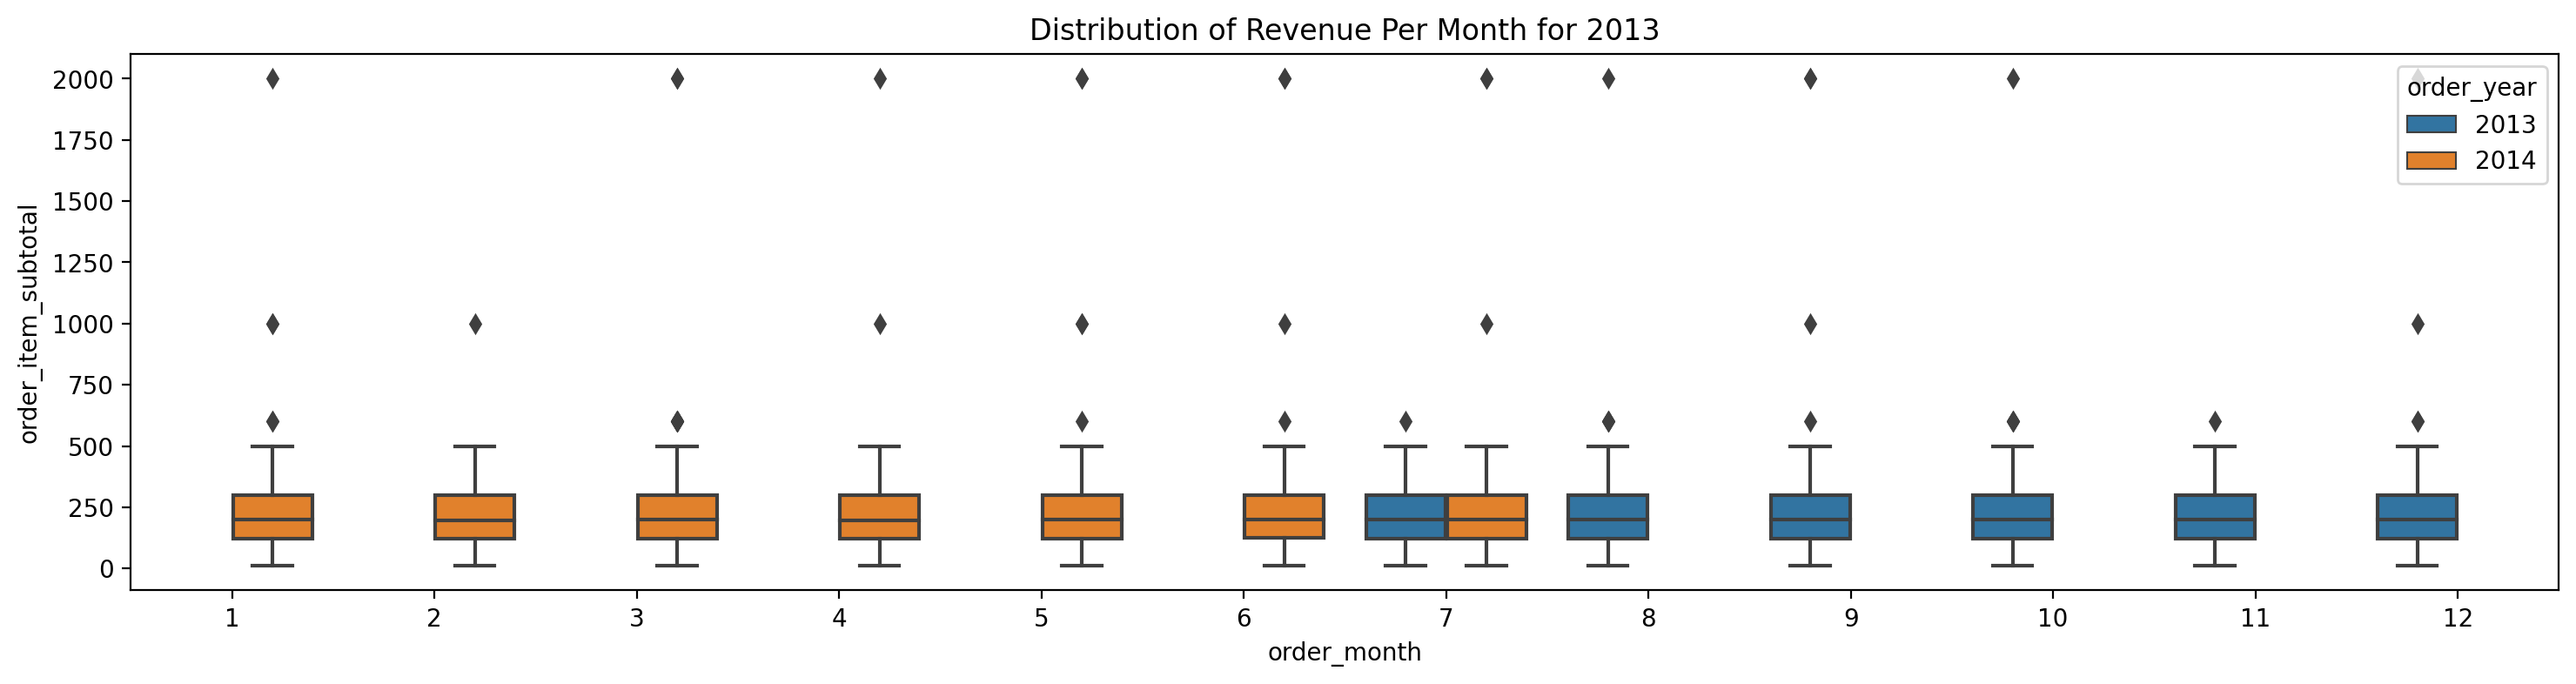

In [0]:
b = sns.boxplot(x='order_month', y='order_item_subtotal', hue='order_year', data=revenue)
b.set_title('Distribution of Revenue Per Month for 2013')

##### RollUps: A rollup is a multidimensional aggregation that performs a variety of group-by style calculation. When we do a rollup based on order_year and order_month then we get the following multidimensional aggregations:

    total revenue irrespective of the order_year and order_month

    total revenue per order_year irrespective of the order_month

    total revenue per order_year per order_month

In [0]:
(rev_df.rollup("order_year","order_month")
       .agg(F.sum(col('order_item_subtotal')).cast(DecimalType(38, 2)).alias("total_revenue"))
       .orderBy(['order_year', 'order_month'])
       .show(50))

+----------+-----------+-------------+
|order_year|order_month|total_revenue|
+----------+-----------+-------------+
|      null|       null|  34322620.60|
|      2013|       null|  15254189.37|
|      2013|          7|    764782.20|
|      2013|          8|   2828658.75|
|      2013|          9|   2934527.33|
|      2013|         10|   2624600.66|
|      2013|         11|   3168656.09|
|      2013|         12|   2932964.33|
|      2014|       null|  19068431.23|
|      2014|          1|   2924447.07|
|      2014|          2|   2778663.71|
|      2014|          3|   2862492.27|
|      2014|          4|   2807789.85|
|      2014|          5|   2753078.27|
|      2014|          6|   2703463.49|
|      2014|          7|   2238496.56|
+----------+-----------+-------------+



##### Cube: In rollup above we did not get the aggregation

    total revenue per order_month irrespective of the order_year

##### Rollup treats elements hierarchically and since order_month was the last element in the group-by clause so it is treated as the last level of hierarchy and hence to grouping was performed on order_month alone. 

##### We can use cube here. A cube takes the rollup to a level deeper. Rather than treating elements hierarchically, a cube does the same thing across all dimensions. This means it won’t just go by order_year over the entire time period, but also the order_month.

Using cube helps to answer all the of the following in one aggregate DataFrame.

    total revenue irrespective of the order_year and order_month

    total revenue per order_year irrespective of the order_month

    total revenue per order_month irrespective of the order_year

    total revenue per order_year per order_month

In [0]:
(rev_df.cube('order_year','order_month')
       .agg(F.sum(col('order_item_subtotal')).alias('total_sales'))
       .orderBy(['order_year','order_month'])
       .show(50))

+----------+-----------+--------------------+
|order_year|order_month|         total_sales|
+----------+-----------+--------------------+
|      null|       null| 3.432262059842491E7|
|      null|          1|  2924447.0670757294|
|      null|          2|  2778663.7149181366|
|      null|          3|   2862492.265932083|
|      null|          4|  2807789.8547916412|
|      null|          5|  2753078.2738227844|
|      null|          6|   2703463.491306305|
|      null|          7|   3003278.769226074|
|      null|          8|   2828658.754573822|
|      null|          9|  2934527.3265972137|
|      null|         10|  2624600.6605644226|
|      null|         11|  3168656.0921707153|
|      null|         12|   2932964.327445984|
|      2013|       null|1.5254189366077423E7|
|      2013|          7|   764782.2047252655|
|      2013|          8|   2828658.754573822|
|      2013|          9|  2934527.3265972137|
|      2013|         10|  2624600.6605644226|
|      2013|         11|  3168656.

### 4.5: Top Performing Departments:

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT d.department_name, YEAR(o.order_date) as year, ROUND(SUM(oi.order_item_subtotal), 2) as total_revenue
            FROM orders o INNER JOIN order_items oi on o.order_id = oi.order_item_order_id
            INNER JOIN products p  on oi.order_item_product_id = p.product_id
            INNER JOIN categories c on c.category_id = p.product_category_id
            INNER JOIN departments d on c.category_department_id = d.department_id
            WHERE o.order_status <> 'CANCELLED' AND o.order_status <> 'SUSPECTED_FRAUD'
            GROUP BY d.department_name, year
            ORDER BY d.department_name, year
''').show(truncate=False)

+---------------+----+-------------+
|department_name|year|total_revenue|
+---------------+----+-------------+
|Apparel        |2013|3156217.05   |
|Apparel        |2014|3998845.48   |
|Fan Shop       |2013|7446893.45   |
|Fan Shop       |2014|9279145.4    |
|Fitness        |2013|121562.18    |
|Fitness        |2014|152855.76    |
|Footwear       |2013|1751846.98   |
|Footwear       |2014|2168965.58   |
|Golf           |2013|2008599.26   |
|Golf           |2014|2496586.25   |
|Outdoors       |2013|429515.74    |
|Outdoors       |2014|544742.77    |
+---------------+----+-------------+



##### DF API

In [0]:
df = (order_df.filter((order_df.order_status != 'CANCELLED') & (order_df.order_status != 'SUSPECTED_FRAUD'))
              .join(order_item_df,order_df.order_id == order_item_df.order_item_order_id, how='inner')
              .join(product_df, order_item_df.order_item_product_id == product_df.product_id, how='inner')
              .join(category_df, product_df.product_category_id == category_df.category_id, how='inner')
              .join(department_df, category_df.category_department_id == department_df.department_id, how='inner')
              .select('department_name', F.year(order_df.order_date).alias('order_year'), 'order_item_subtotal')
              .groupBy(['department_name','order_year'])
              .agg(F.round( F.sum(order_item_df.order_item_subtotal), 2).alias('total_revenue'))
              .orderBy('department_name','order_year'))
df.cache()

DataFrame[department_name: string, order_year: int, total_revenue: double]

In [0]:
df.show()

+---------------+----------+-------------+
|department_name|order_year|total_revenue|
+---------------+----------+-------------+
|        Apparel|      2013|   3156217.05|
|        Apparel|      2014|   3998845.48|
|       Fan Shop|      2013|   7446893.45|
|       Fan Shop|      2014|    9279145.4|
|        Fitness|      2013|    121562.18|
|        Fitness|      2014|    152855.76|
|       Footwear|      2013|   1751846.98|
|       Footwear|      2014|   2168965.58|
|           Golf|      2013|   2008599.26|
|           Golf|      2014|   2496586.25|
|       Outdoors|      2013|    429515.74|
|       Outdoors|      2014|    544742.77|
+---------------+----------+-------------+



In [0]:
pandas_df = df.toPandas()

In [0]:
pandas_df = pandas_df.pivot(index='department_name', columns='order_year', values='total_revenue')

In [0]:
print(pandas_df)

order_year             2013        2014
department_name                        
Apparel          3156217.05  3998845.48
Fan Shop         7446893.45  9279145.40
Fitness           121562.18   152855.76
Footwear         1751846.98  2168965.58
Golf             2008599.26  2496586.25
Outdoors          429515.74   544742.77


<AxesSubplot:title={'center':'Top Performing Departments'}, xlabel='department_name'>

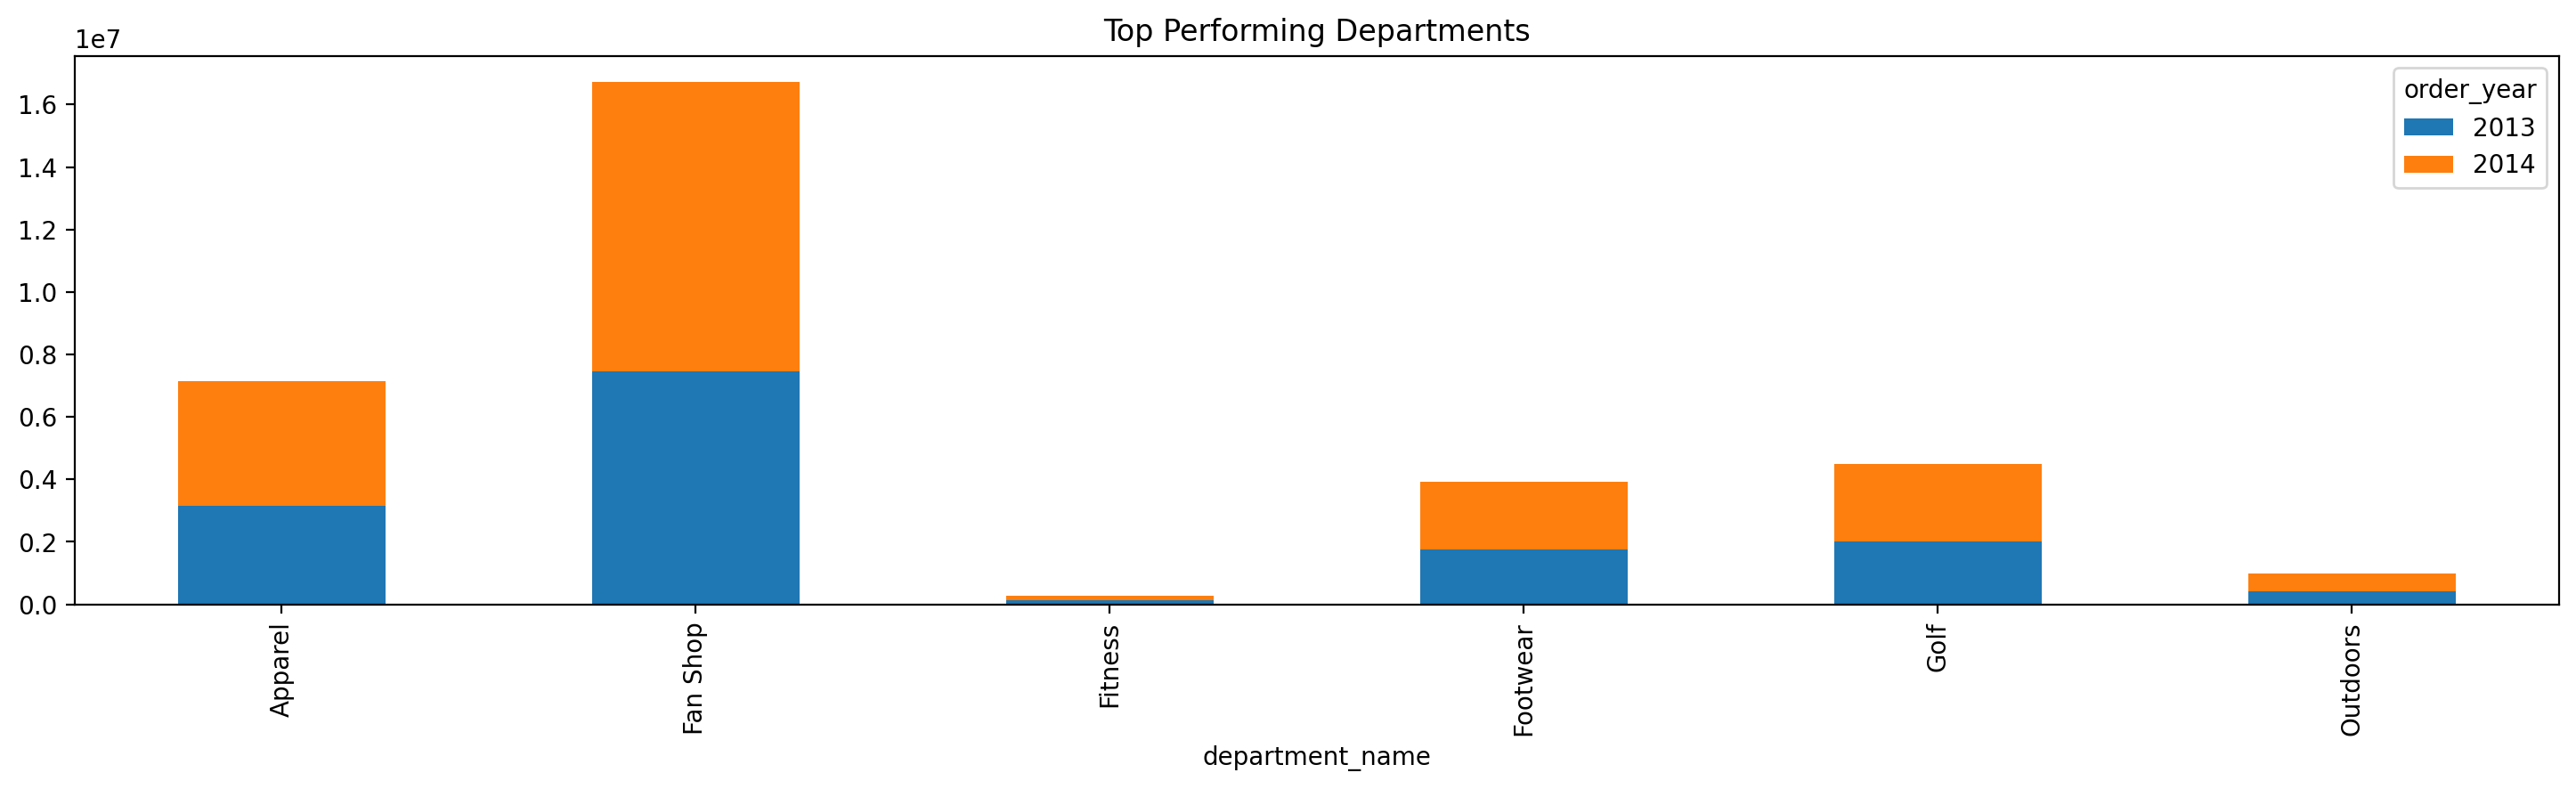

In [0]:
pandas_df.plot.bar(stacked=True, title='Top Performing Departments')

In [0]:
df.unpersist()

DataFrame[department_name: string, order_year: int, total_revenue: double]

### 4.6: Highest Priced Product

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT p.* from products p where p.price = ( SELECT MAX(q.price) from products q )
''').show()

+----------+-------------------+-------------------+-----------+-------+--------------------+
|product_id|product_category_id|       product_name|description|  price|               image|
+----------+-------------------+-------------------+-----------+-------+--------------------+
|       208|                 10|SOLE E35 Elliptical|       null|1999.99|http://images.acm...|
+----------+-------------------+-------------------+-----------+-------+--------------------+



In [0]:
### We can also use RANK() Window Function to get highest priced product
spark.sql('''
         SELECT * FROM (
         SELECT *, RANK() OVER( ORDER BY price DESC ) AS rank FROM products
         ) p where p.rank = 1
''').show()

+----------+-------------------+-------------------+-----------+-------+--------------------+----+
|product_id|product_category_id|       product_name|description|  price|               image|rank|
+----------+-------------------+-------------------+-----------+-------+--------------------+----+
|       208|                 10|SOLE E35 Elliptical|       null|1999.99|http://images.acm...|   1|
+----------+-------------------+-------------------+-----------+-------+--------------------+----+



##### DF API

In [0]:
(product_df.select('*')
           .filter(col('price') == product_df.select(F.max('price')).collect()[0][0])
           .show())

+----------+-------------------+-------------------+-----------+-------+--------------------+
|product_id|product_category_id|       product_name|description|  price|               image|
+----------+-------------------+-------------------+-----------+-------+--------------------+
|       208|                 10|SOLE E35 Elliptical|       null|1999.99|http://images.acm...|
+----------+-------------------+-------------------+-----------+-------+--------------------+



##### DF API using Windows Function

In [0]:
windowProd = Window.orderBy(product_df['price'].desc())
product_df.select('*', F.rank().over(windowProd).alias('rank')).filter(col('rank') == 1).show()


+----------+-------------------+-------------------+-----------+-------+--------------------+----+
|product_id|product_category_id|       product_name|description|  price|               image|rank|
+----------+-------------------+-------------------+-----------+-------+--------------------+----+
|       208|                 10|SOLE E35 Elliptical|       null|1999.99|http://images.acm...|   1|
+----------+-------------------+-------------------+-----------+-------+--------------------+----+



### 4.7 Highest Revenue Earning Product

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT p.*,r. prod_revenue
            FROM products p, (SELECT oi.order_item_product_id, ROUND( SUM(CAST(order_item_subtotal as float)), 2) as prod_revenue
                              FROM order_items oi
                              GROUP BY order_item_product_id
                              ORDER BY prod_revenue DESC
                              LIMIT 1) r
           WHERE product_id = r.order_item_product_id
''').show()

+----------+-------------------+--------------------+-----------+------+--------------------+------------+
|product_id|product_category_id|        product_name|description| price|               image|prod_revenue|
+----------+-------------------+--------------------+-----------+------+--------------------+------------+
|      1004|                 45|Field & Stream Sp...|       null|399.98|http://images.acm...|  6929653.69|
+----------+-------------------+--------------------+-----------+------+--------------------+------------+



In [0]:
### TOP 10 Revenue Generating Products
spark.sql('''
            SELECT p.product_id, p.product_category_id, p.product_name, r.product_revenue
            FROM products p INNER JOIN (
                                SELECT oi.order_item_product_id, round(SUM(CAST(oi.order_item_subtotal as float)), 2) as product_revenue
                                FROM order_items oi INNER JOIN orders o 
                                ON oi.order_item_order_id = o.order_id
                                WHERE o.order_status <> 'CANCELED'
                                AND o.order_status <> 'SUSPECTED_FRAUD'
                                GROUP BY oi.order_item_product_id) r
                                ON p.product_id = r.order_item_product_id
                                ORDER BY r.product_revenue DESC
                                LIMIT 10            

''').show(truncate = False)

+----------+-------------------+---------------------------------------------+---------------+
|product_id|product_category_id|product_name                                 |product_revenue|
+----------+-------------------+---------------------------------------------+---------------+
|1004      |45                 |Field & Stream Sportsman 16 Gun Fire Safe    |6637668.28     |
|365       |17                 |Perfect Fitness Perfect Rip Deck             |4233794.37     |
|957       |43                 |Diamondback Women's Serene Classic Comfort Bi|3946837.0      |
|191       |9                  |Nike Men's Free 5.0+ Running Shoe            |3507549.21     |
|502       |24                 |Nike Men's Dri-FIT Victory Golf Polo         |3011600.0      |
|1073      |48                 |Pelican Sunstream 100 Kayak                  |2967851.68     |
|1014      |46                 |O'Brien Men's Neoprene Life Vest             |2765543.31     |
|403       |18                 |Nike Men's CJ Elit

##### DF API

In [0]:
### Steps To Follow
# 1. Get the sum of revenue of all the products grouped by order_item_product_id from order_items table
# 2. Sort the result in descending order of their revenues
# 3. Take only the first one from the sorted order using the limit() function
# 4. Join with the prorcuts column to get the product details
(order_item_df.select(['order_item_product_id','order_item_subtotal'])
              .groupBy('order_item_product_id')
              .agg(F.round( F.sum(col('order_item_subtotal')), 2).alias('product_revenue'))
              .orderBy('product_revenue',ascending=False)
              .limit(1)
              .join(product_df,order_item_df.order_item_product_id == product_df.product_id, how='inner')
              .select('product_id', 'product_category_id', 'product_name', 'product_revenue')
              .show(truncate=False)
)

+----------+-------------------+-----------------------------------------+---------------+
|product_id|product_category_id|product_name                             |product_revenue|
+----------+-------------------+-----------------------------------------+---------------+
|1004      |45                 |Field & Stream Sportsman 16 Gun Fire Safe|6929653.69     |
+----------+-------------------+-----------------------------------------+---------------+



### 4.8 Top 5 Highest Revenue Earning Products Per Month Per Year

##### SPARK SQL

In [0]:
# Map from month number to actual month 
monthMap = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

#Register User-Define Function udf with SQLContext
sqlContext.udf.register('udfmonToMonth', lambda m: monthMap[m], StringType())


<function __main__.<lambda>(m)>

In [0]:
df = spark.sql('''
                SELECT p.* FROM ( SELECT r.*, DENSE_RANK() OVER (PARTITION BY order_year,order_month ORDER BY prod_revenue DESC) as dense_rank
                        FROM (
                            SELECT YEAR(o.order_date) as order_year, udfmonToMonth(MONTH(o.order_date)) as order_month, 
                            p.product_name, ROUND(SUM(CAST(oi.order_item_subtotal AS float)),2) as prod_revenue 
                             FROM order_items oi INNER JOIN orders o  ON oi.order_item_order_id = o.order_id
                                                 INNER JOIN products p ON oi.order_item_product_id = p.product_id
                             WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
                             GROUP BY order_year, order_month, p.product_name 
                    ) r
                ) p 
                WHERE p.dense_rank <= 5
                ORDER BY p.order_year,p.order_month,p.dense_rank

''')

df.cache()

DataFrame[order_year: int, order_month: string, product_name: string, prod_revenue: double, dense_rank: int]

In [0]:
df.show(truncate=False)

+----------+-----------+---------------------------------------------+------------+----------+
|order_year|order_month|product_name                                 |prod_revenue|dense_rank|
+----------+-----------+---------------------------------------------+------------+----------+
|2013      |Aug        |Field & Stream Sportsman 16 Gun Fire Safe    |540772.97   |1         |
|2013      |Aug        |Perfect Fitness Perfect Rip Deck             |349861.69   |2         |
|2013      |Aug        |Diamondback Women's Serene Classic Comfort Bi|319778.69   |3         |
|2013      |Aug        |Nike Men's Free 5.0+ Running Shoe            |279172.08   |4         |
|2013      |Aug        |Nike Men's Dri-FIT Victory Golf Polo         |247700.0    |5         |
|2013      |Dec        |Field & Stream Sportsman 16 Gun Fire Safe    |595570.24   |1         |
|2013      |Dec        |Perfect Fitness Perfect Rip Deck             |342842.86   |2         |
|2013      |Dec        |Diamondback Women's Serene

In [0]:
df_Pandas = df.toPandas()

##### For 2014:

Text(0.5, 1.0, 'Top 5 Highest Revenue Earning Products Per Month in 2014')

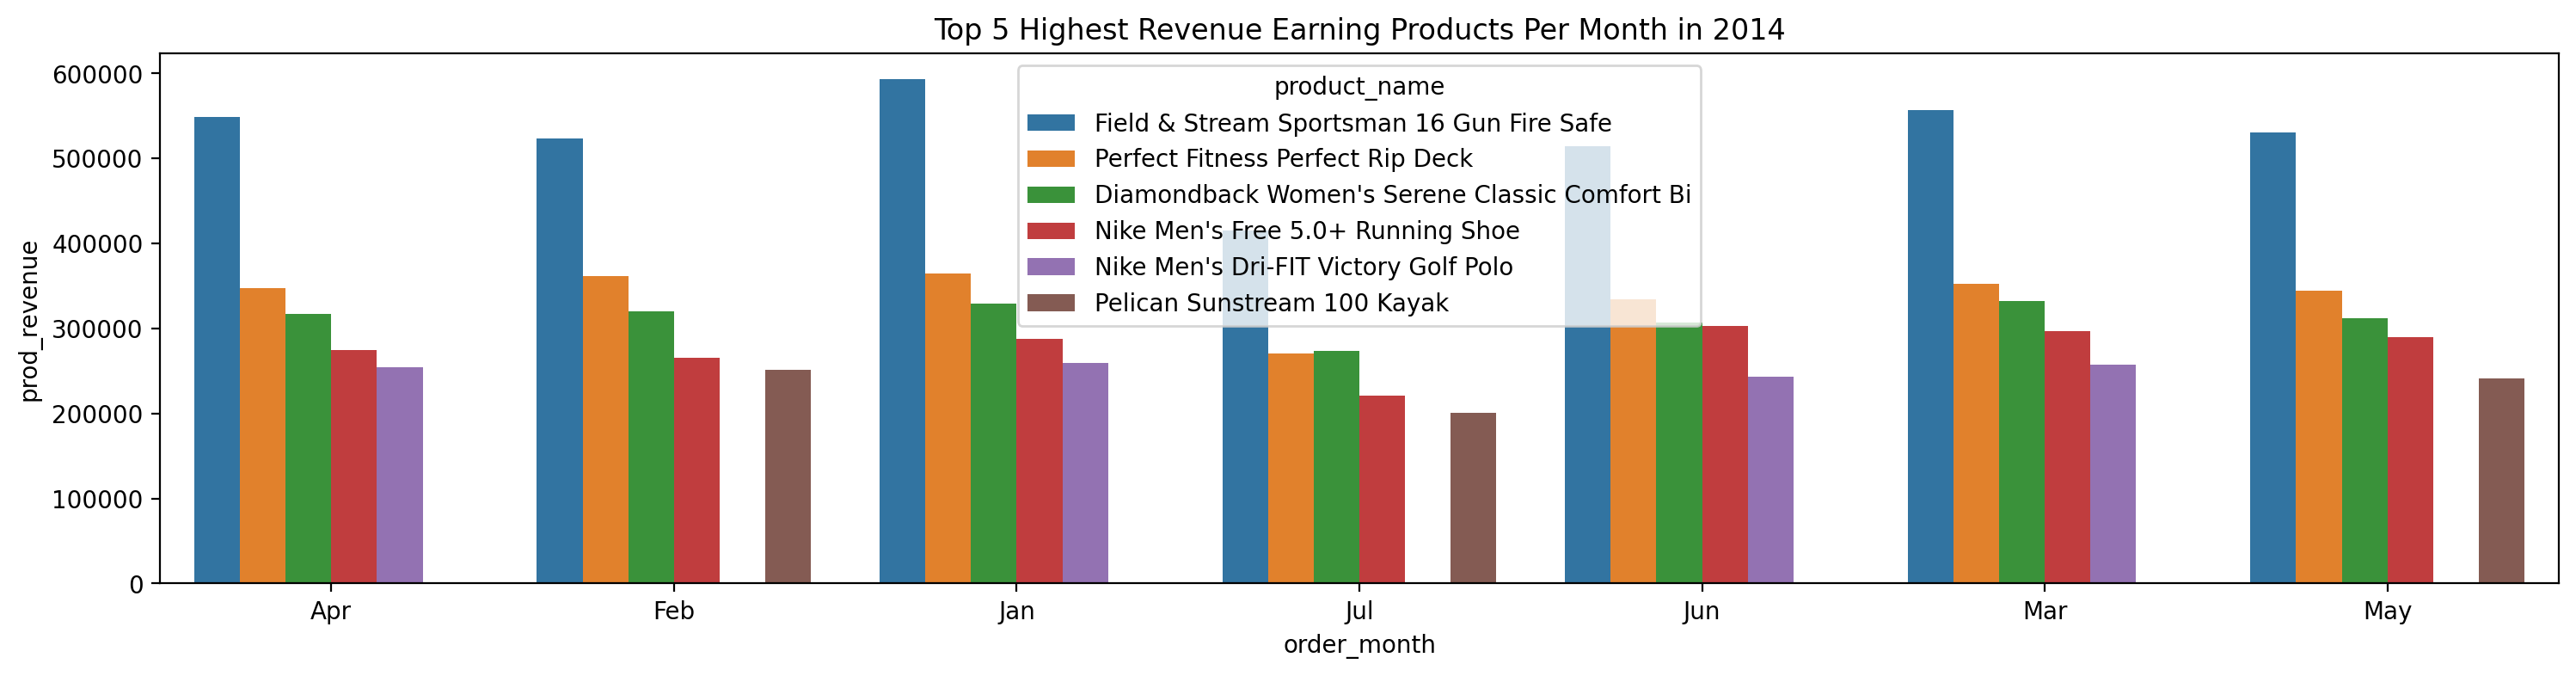

In [0]:
df_2014 = sns.barplot(x='order_month', y='prod_revenue', hue="product_name", data=df_Pandas[df_Pandas['order_year'] == 2014])
df_2014.set_title("Top 5 Highest Revenue Earning Products Per Month in 2014")

Text(0.5, 1.0, 'Top 5 Highest Revenue Earning Products Per Month in 2013')

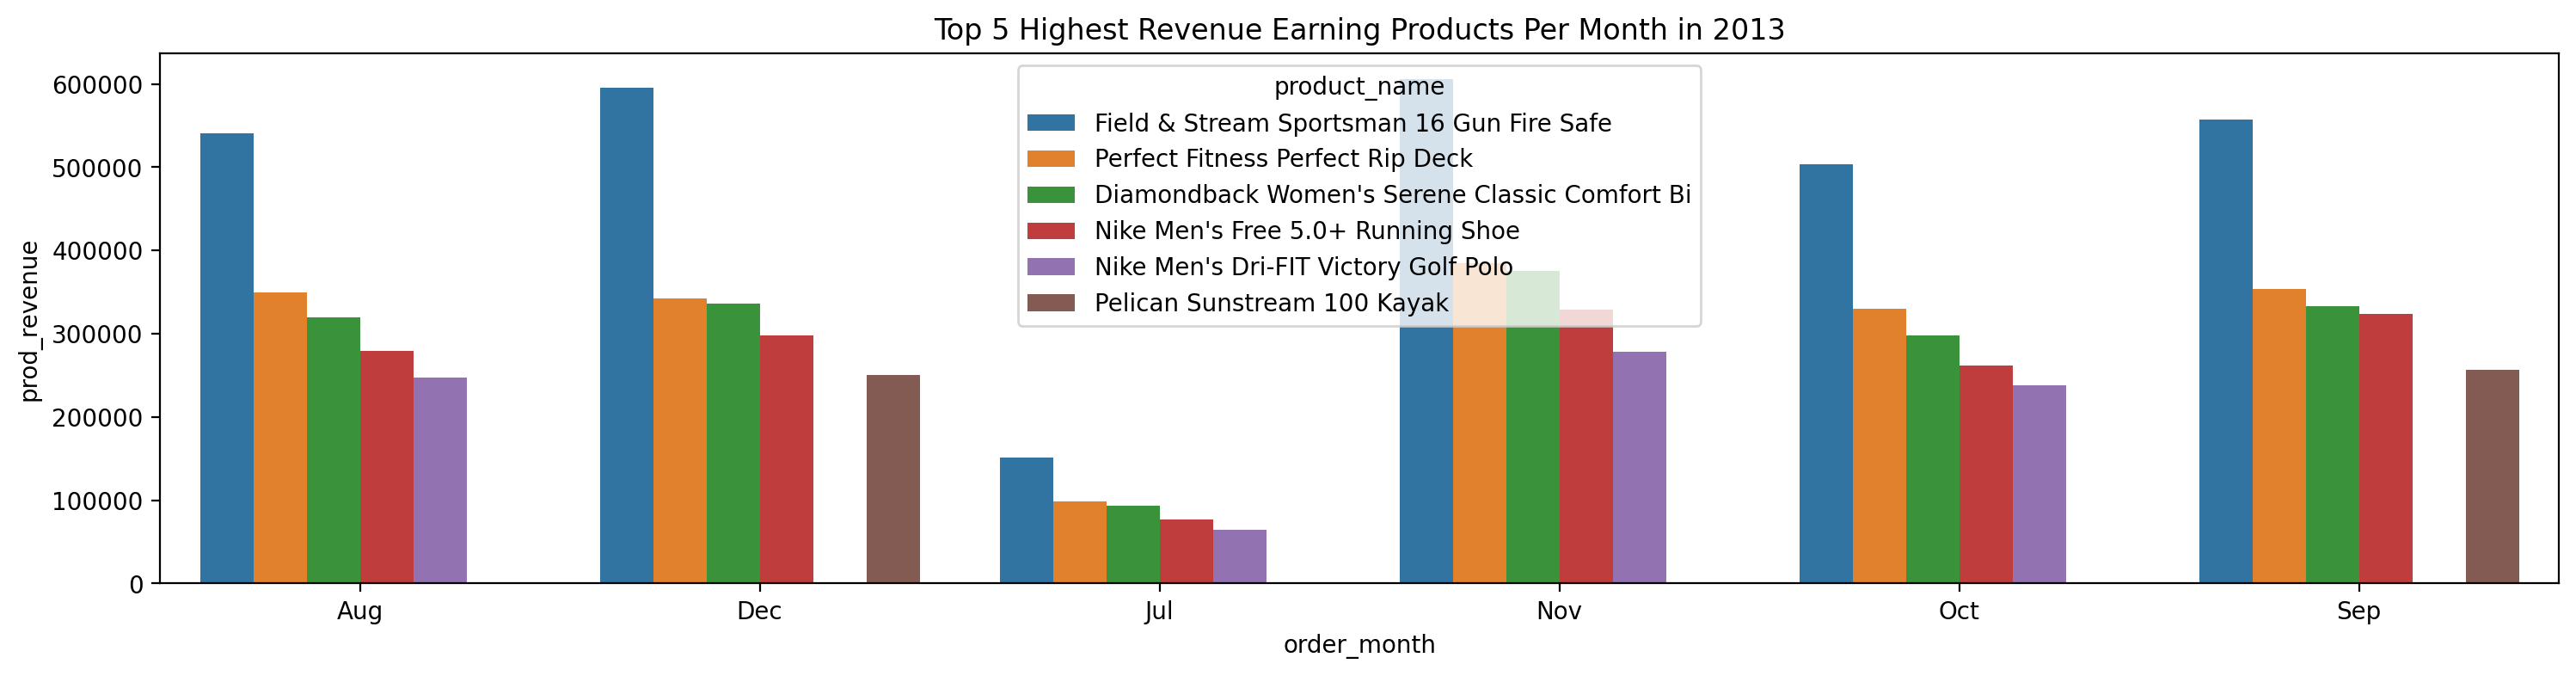

In [0]:
df_2013 = sns.barplot(x='order_month', y='prod_revenue', hue="product_name", data=df_Pandas[df_Pandas['order_year'] == 2013])
df_2013.set_title("Top 5 Highest Revenue Earning Products Per Month in 2013")

In [0]:
df.unpersist()

DataFrame[order_year: int, order_month: string, product_name: string, prod_revenue: double, dense_rank: int]

##### DF API

In [0]:
udfmonToMonth = udf(lambda m : monthMap[m], StringType())


In [0]:
rev_per_month_per_year_per_product = (order_df
                     .select(F.year('order_date').alias('order_year'), udfmonToMonth(F.month('order_date')).alias('order_month'),'order_id', 'order_status')
                     .where((col('order_status') != 'CANCELED') & (col('order_status') != 'SUSPECTED_FRAUD'))
                     .join(order_item_df, order_df.order_id == order_item_df.order_item_order_id, how='inner')
                     .join(product_df, order_item_df.order_item_product_id == product_df.product_id, how='inner')
                     .select(['order_year', 'order_month', 'product_name', 'order_item_subtotal'])
                     .groupBy(['order_year','order_month','product_name'])
                     .agg(F.round(F.sum('order_item_subtotal'), 2).alias('product_revenue')))
                        
rev_per_month_per_year_per_product.cache()                        
                        
                        
                        
                        

DataFrame[order_year: int, order_month: string, product_name: string, product_revenue: double]

In [0]:
rev_per_month_per_year_per_product.show(5, truncate=False)

+----------+-----------+---------------------------------------------+---------------+
|order_year|order_month|product_name                                 |product_revenue|
+----------+-----------+---------------------------------------------+---------------+
|2013      |Nov        |Under Armour Women's Micro G Skulpt Running S|3792.93        |
|2013      |Oct        |Polar Loop Activity Tracker                  |329.85         |
|2014      |Jan        |Bushnell Pro X7 Jolt Slope Rangefinder       |599.99         |
|2013      |Aug        |Hirzl Men's Hybrid Golf Glove                |1064.29        |
|2014      |Feb        |Titleist Small Wheeled Travel Cover          |249.99         |
+----------+-----------+---------------------------------------------+---------------+
only showing top 5 rows



In [0]:
windowRevenue = Window.partitionBy([rev_per_month_per_year_per_product.order_year, rev_per_month_per_year_per_product.order_month]).orderBy(rev_per_month_per_year_per_product.product_revenue.desc())

In [0]:
top_prod_per_month_per_year_by_rev = (rev_per_month_per_year_per_product
                                      .select('*',F.dense_rank().over(windowRevenue).alias('dense_rank'))
                                      .filter(col('dense_rank') <= 5)
                                      .orderBy(['order_year','order_month','dense_rank'])
                                     )

top_prod_per_month_per_year_by_rev.cache()

DataFrame[order_year: int, order_month: string, product_name: string, product_revenue: double, dense_rank: int]

In [0]:
top_prod_per_month_per_year_by_rev.show(truncate=False)

+----------+-----------+---------------------------------------------+---------------+----------+
|order_year|order_month|product_name                                 |product_revenue|dense_rank|
+----------+-----------+---------------------------------------------+---------------+----------+
|2013      |Aug        |Field & Stream Sportsman 16 Gun Fire Safe    |540772.97      |1         |
|2013      |Aug        |Perfect Fitness Perfect Rip Deck             |349861.69      |2         |
|2013      |Aug        |Diamondback Women's Serene Classic Comfort Bi|319778.69      |3         |
|2013      |Aug        |Nike Men's Free 5.0+ Running Shoe            |279172.08      |4         |
|2013      |Aug        |Nike Men's Dri-FIT Victory Golf Polo         |247700.0       |5         |
|2013      |Dec        |Field & Stream Sportsman 16 Gun Fire Safe    |595570.24      |1         |
|2013      |Dec        |Perfect Fitness Perfect Rip Deck             |342842.86      |2         |
|2013      |Dec     

In [0]:
rev_per_month_per_year_per_product.unpersist()
top_prod_per_month_per_year_by_rev.unpersist()

DataFrame[order_year: int, order_month: string, product_name: string, product_revenue: double, dense_rank: int]

### 4.9 Most Popular Categories

In [0]:
spark.sql('''
            SELECT c.category_name,COUNT(order_item_quantity) as order_count
            FROM order_items oi INNER JOIN products p on  oi.order_item_product_id = p.product_id
            INNER JOIN categories c on c.category_id = p.product_category_id
            GROUP BY c.category_name
            ORDER BY order_count DESC 
            LIMIT 10
''').show()

+--------------------+-----------+
|       category_name|order_count|
+--------------------+-----------+
|              Cleats|      24551|
|      Men's Footwear|      22246|
|     Women's Apparel|      21035|
|Indoor/Outdoor Games|      19298|
|             Fishing|      17325|
|        Water Sports|      15540|
|    Camping & Hiking|      13729|
|    Cardio Equipment|      12487|
|       Shop By Sport|      10984|
|         Electronics|       3156|
+--------------------+-----------+



##### DF API

In [0]:
popular_cat = (order_item_df.join(product_df, order_item_df.order_item_product_id == product_df.product_id, how='inner')
                            .join(category_df, category_df.category_id == product_df.product_category_id, how='inner')
                            .groupBy('category_name')
                            .agg(F.count('order_item_quantity').alias('order_count'))
                            .orderBy('order_count',ascending=False)
                            .limit(10)
              )

popular_cat.cache()

DataFrame[category_name: string, order_count: bigint]

In [0]:
popular_cat.show()

+--------------------+-----------+
|       category_name|order_count|
+--------------------+-----------+
|              Cleats|      24551|
|      Men's Footwear|      22246|
|     Women's Apparel|      21035|
|Indoor/Outdoor Games|      19298|
|             Fishing|      17325|
|        Water Sports|      15540|
|    Camping & Hiking|      13729|
|    Cardio Equipment|      12487|
|       Shop By Sport|      10984|
|         Electronics|       3156|
+--------------------+-----------+



In [0]:
popular_cat_df = popular_cat.toPandas()

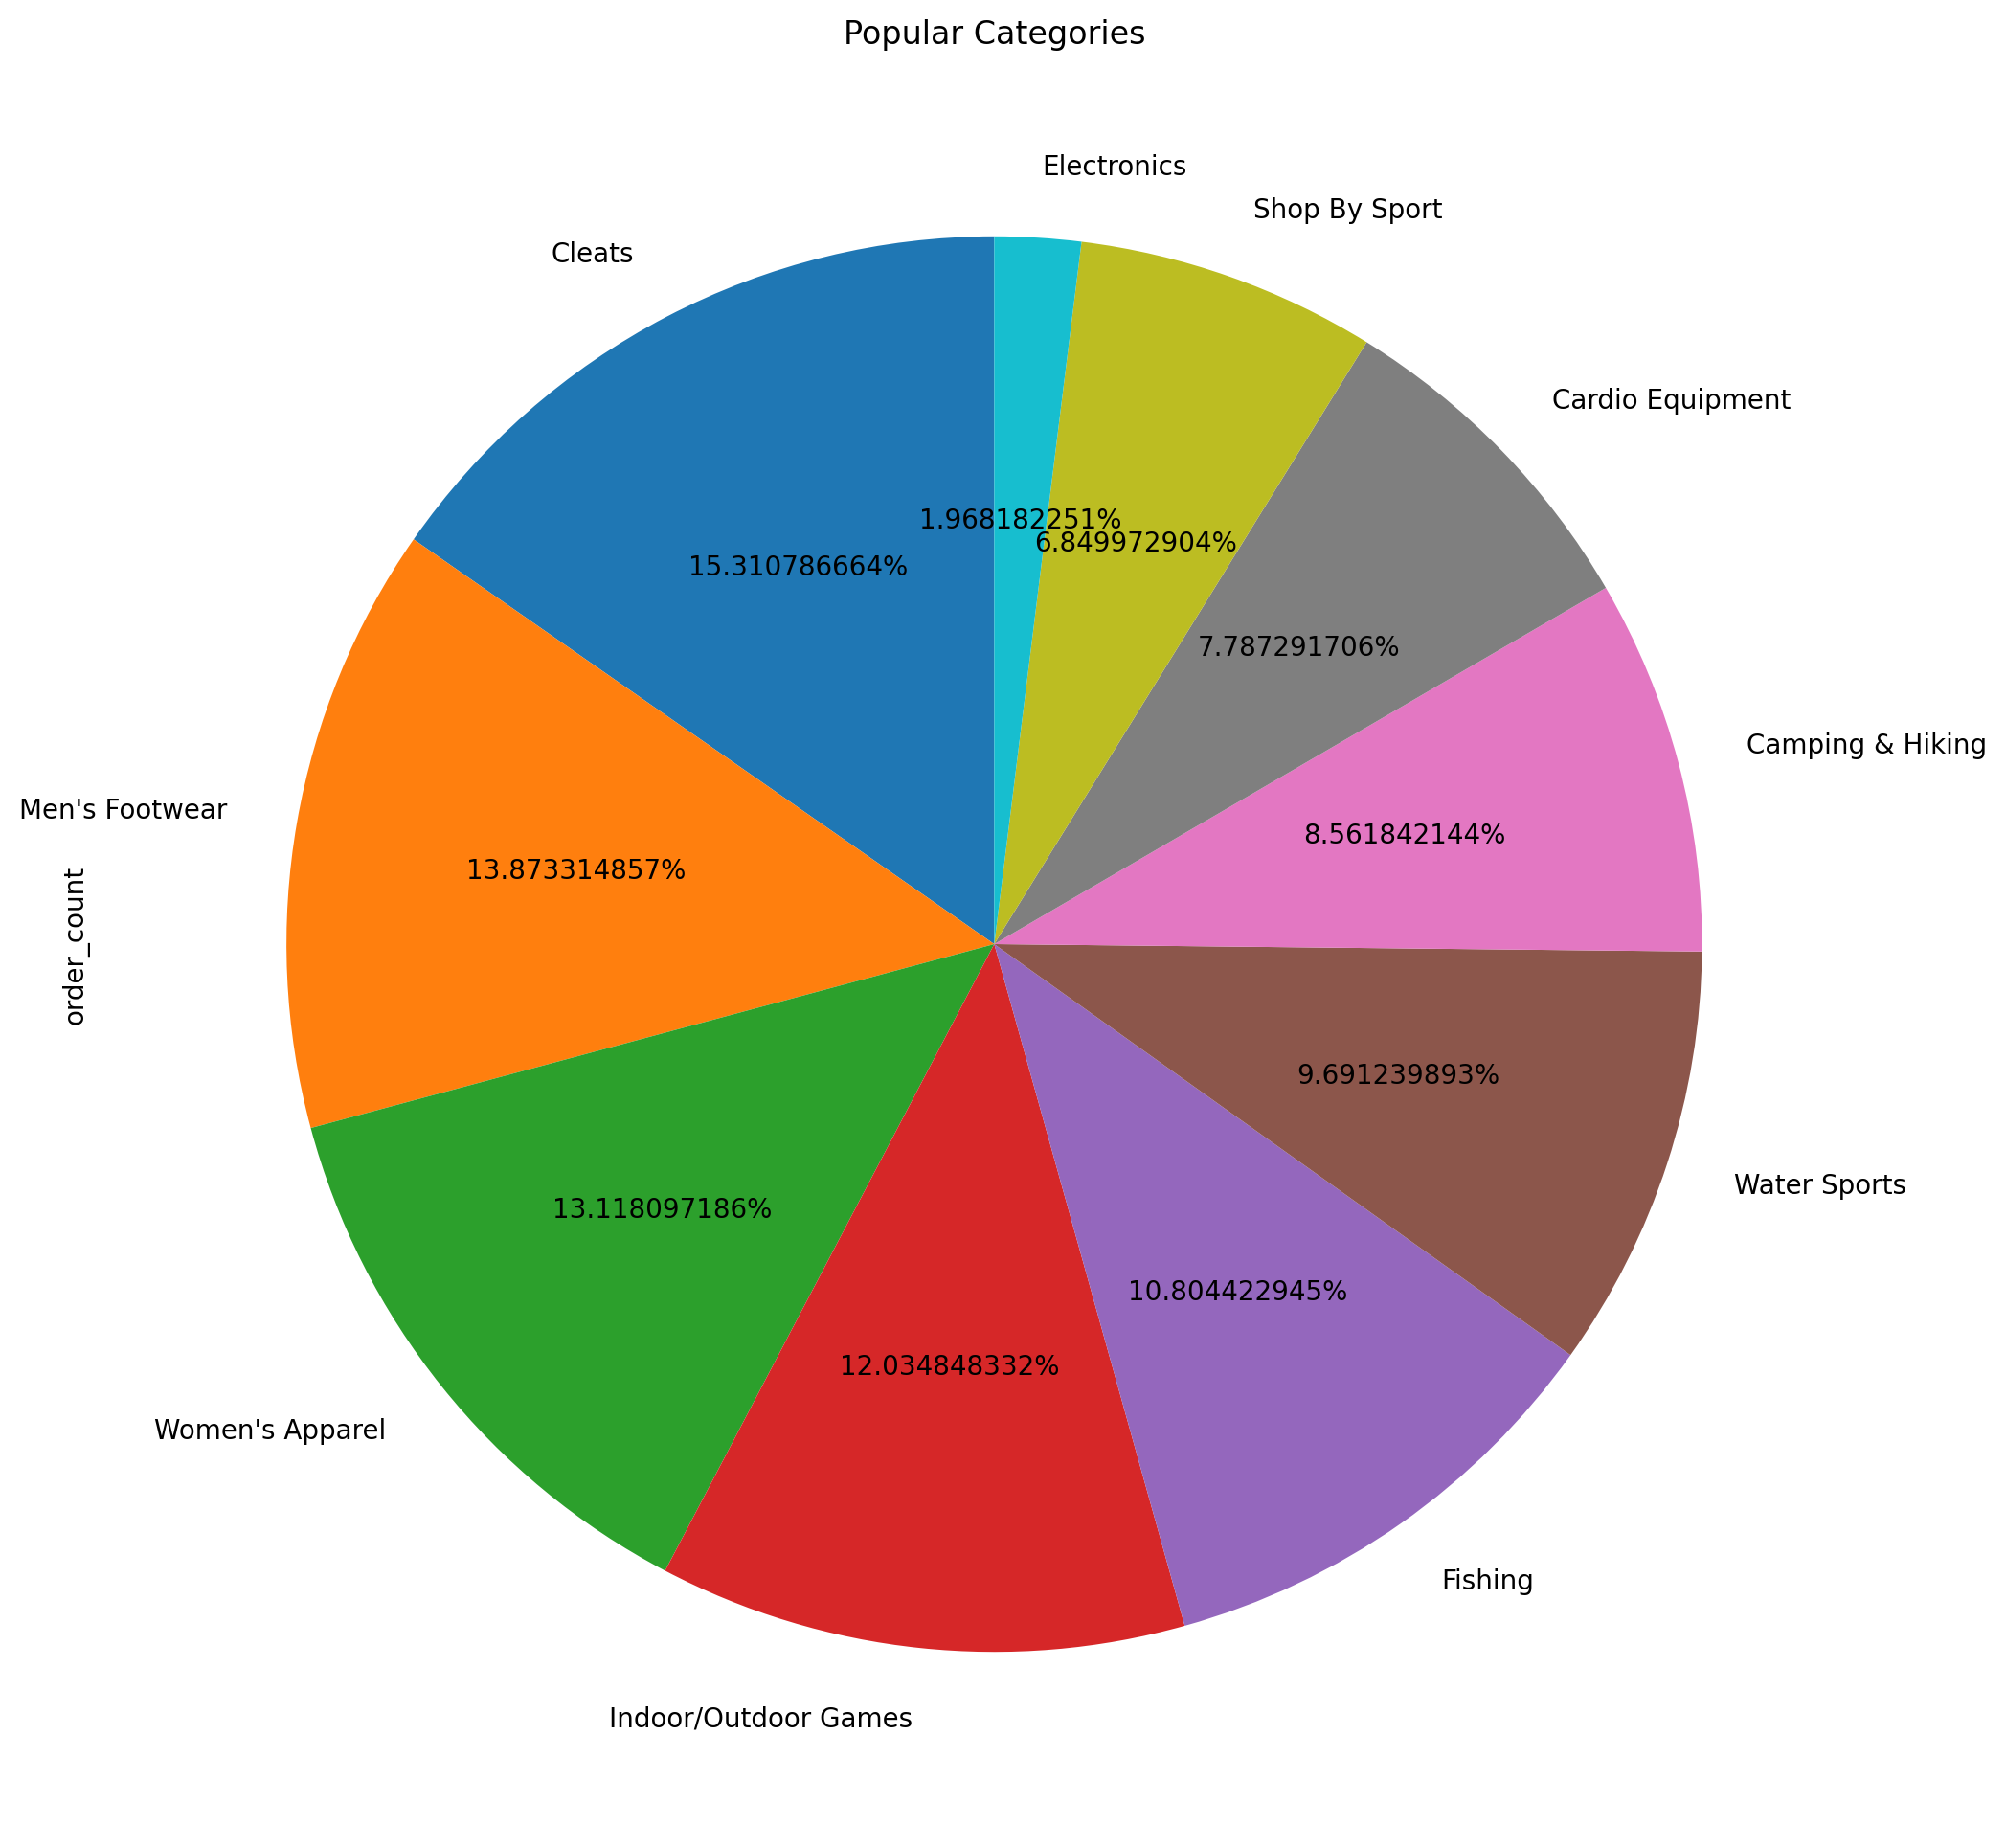

In [0]:
(popular_cat_df.plot(kind='pie', y='order_count', autopct='%3.9f%%', startangle=90, labels=popular_cat_df['category_name'], legend=False, title='Popular Categories', figsize=(12, 12)));

In [0]:
popular_cat.unpersist()

DataFrame[category_name: string, order_count: bigint]

### 4.10 Get the Revenue for each Category Per Year Per Quarter:

#### Reshaping Data with Pivot in Apache Spark:

In [0]:
### pivot is applied after a groupBy operation. It pivots on a pivotColumn column, i.e. adds new columns per distinct values in pivotColumn and the values from the groupBy operation becomes the values in the correponding new distinct valued columns.

### Let us first generate a subdataframe where we extract out the quarter from the order date. We would find the total per quarter for a given category per year.


##### DF + SQL Combination (prior to Spark 2.4.0)

In [0]:
revenue_cat_qtr = spark.sql('''
                    SELECT c.category_name, YEAR(o.order_date) as order_year, CONCAT('Q', QUARTER(o.order_date)) as order_quarter, order_item_subtotal
                    FROM orders o INNER JOIN order_items oi ON o.order_id = oi.order_item_order_id
                    INNER JOIN products p ON oi.order_item_product_id = p.product_id
                    INNER JOIN categories c ON p.product_category_id = c.category_id
                    WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'

''')

revenue_cat_qtr.cache()

DataFrame[category_name: string, order_year: int, order_quarter: string, order_item_subtotal: float]

In [0]:
revenue_cat_qtr.show()

+--------------------+----------+-------------+-------------------+
|       category_name|order_year|order_quarter|order_item_subtotal|
+--------------------+----------+-------------+-------------------+
|    Camping & Hiking|      2013|           Q3|             299.98|
|        Water Sports|      2013|           Q3|             199.99|
|     Women's Apparel|      2013|           Q3|              250.0|
|      Men's Footwear|      2013|           Q3|             129.99|
|         Accessories|      2013|           Q3|              49.98|
|              Cleats|      2013|           Q3|             299.95|
|     Women's Apparel|      2013|           Q3|              150.0|
|Indoor/Outdoor Games|      2013|           Q3|             199.92|
|    Camping & Hiking|      2013|           Q3|             299.98|
|              Cleats|      2013|           Q3|             299.95|
|Indoor/Outdoor Games|      2013|           Q3|              99.96|
|    Camping & Hiking|      2013|           Q3| 

In [0]:
revenue_cat_qtr_df = (revenue_cat_qtr
                      .groupBy('category_name', 'order_year')
                      .pivot('order_quarter', ['Q1', 'Q2', 'Q3', 'Q4']) # specifying the unique values (if we know) for pivot column makes execution faster
                      .agg(F.round(F.sum('order_item_subtotal'), 2))
                      .withColumn('total_sales', F.round(F.coalesce(col('Q1'), F.lit(0)) + F.coalesce(col('Q2'), F.lit(0)) + F.coalesce(col('Q3'), F.lit(0)) + F.coalesce(col('Q4'), F.lit(0)), 2))
                      .orderBy('total_sales', ascending=False))

revenue_cat_qtr_df.cache()                

DataFrame[category_name: string, order_year: int, Q1: double, Q2: double, Q3: double, Q4: double, total_sales: double]

In [0]:
revenue_cat_qtr_df.show()

+--------------------+----------+----------+----------+----------+----------+-----------+
|       category_name|order_year|        Q1|        Q2|        Q3|        Q4|total_sales|
+--------------------+----------+----------+----------+----------+----------+-----------+
|             Fishing|      2014|1673916.35| 1594720.3| 415179.25|      null|  3683815.9|
|             Fishing|      2013|      null|      null|1248337.61|1705514.77| 2953852.38|
|              Cleats|      2014|1080480.24|1027808.94| 270734.96|      null| 2379024.14|
|    Camping & Hiking|      2014| 981834.58| 935637.65| 273281.79|      null| 2190754.02|
|    Cardio Equipment|      2014| 855664.98| 873333.24| 223277.91|      null| 1952276.13|
|              Cleats|      2013|      null|      null| 806026.14|1059543.73| 1865569.87|
|    Camping & Hiking|      2013|      null|      null| 745750.31|1010332.68| 1756082.99|
|     Women's Apparel|      2014|  756700.0|  728450.0|  196000.0|      null|  1681150.0|
|        W

##### SQL (post Spark 2.4.0) SQL Equivalent Pivot Function

In [0]:
#### Now we can achieve the same with one query instead to DF + SQL combination.
spark.sql('''
            SELECT *, ROUND(COALESCE(Q1,0) + COALESCE(Q2,0) + COALESCE(Q3,0) + COALESCE(Q4,0) , 2) as total_sales from (
                SELECT * FROM (
                    SELECT c.category_name,YEAR(o.order_date) as order_year, CONCAT('Q', QUARTER(o.order_date)) as order_quarter, order_item_subtotal
                    FROM orders o INNER JOIN order_items oi on order_item_order_id = o.order_id
                    INNER JOIN products p on oi.order_item_product_id = p.product_id 
                    INNER JOIN categories c on p.product_category_id = c.category_id
                    WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
                )
                PIVOT (
                     ROUND(SUM(order_item_subtotal), 2)
                     FOR order_quarter in ('Q1', 'Q2', 'Q3', 'Q4')               
                )
            )
            ORDER BY total_sales desc

''').show()


+--------------------+----------+----------+----------+----------+----------+-----------+
|       category_name|order_year|        Q1|        Q2|        Q3|        Q4|total_sales|
+--------------------+----------+----------+----------+----------+----------+-----------+
|             Fishing|      2014|1673916.35| 1594720.3| 415179.25|      null|  3683815.9|
|             Fishing|      2013|      null|      null|1248337.61|1705514.77| 2953852.38|
|              Cleats|      2014|1080480.24|1027808.94| 270734.96|      null| 2379024.14|
|    Camping & Hiking|      2014| 981834.58| 935637.65| 273281.79|      null| 2190754.02|
|    Cardio Equipment|      2014| 855664.98| 873333.24| 223277.91|      null| 1952276.13|
|              Cleats|      2013|      null|      null| 806026.14|1059543.73| 1865569.87|
|    Camping & Hiking|      2013|      null|      null| 745750.31|1010332.68| 1756082.99|
|     Women's Apparel|      2014|  756700.0|  728450.0|  196000.0|      null|  1681150.0|
|        W

##### Revalidate above calculation with a specific year=’2014’ and category=’Water Sports’:

In [0]:
spark.sql('''
            SELECT c.category_name,YEAR(o.order_date) as order_year, concat('Q', QUARTER(o.order_date)) as order_quarter, 
            ROUND(SUM(oi.order_item_subtotal), 2) as order_total
            FROM orders o INNER JOIN order_items oi ON oi.order_item_order_id = o.order_id
            INNER JOIN products p ON oi.order_item_product_id = p.product_id
            INNER JOIN categories c ON p.product_category_id = c.category_id
            WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
            AND YEAR(o.order_date) = 2014
            AND c.category_name = 'Water Sports'
            GROUP BY c.category_name,order_year,order_quarter
            ORDER BY order_year, order_quarter, order_total DESC
            ''').show()

+-------------+----------+-------------+-----------+
|category_name|order_year|order_quarter|order_total|
+-------------+----------+-------------+-----------+
| Water Sports|      2014|           Q1|  740763.07|
| Water Sports|      2014|           Q2|  715814.31|
| Water Sports|      2014|           Q3|  202239.92|
+-------------+----------+-------------+-----------+



###### From the above analysis,three quarters Q1,Q2 and Q3 for Water Sports in 2014  and the sum of the sales is  1,658,817.3

In [0]:
# filter out pivot data for Water Sports in 2014
revenue_cat_qtr_df.filter(col('order_year') == '2014').filter(col('category_name') == 'Water Sports').show()

+-------------+----------+---------+---------+---------+----+-----------+
|category_name|order_year|       Q1|       Q2|       Q3|  Q4|total_sales|
+-------------+----------+---------+---------+---------+----+-----------+
| Water Sports|      2014|740763.07|715814.31|202239.92|null|  1658817.3|
+-------------+----------+---------+---------+---------+----+-----------+



###### From the above pivot table we can verify that Q4 had no sale and the sum of total sales in quarters Q1,Q2 and Q3 for Water Sports in 2014 is 1658817.3
###### Hence, we can verify that our pivot function is working fine.

###### Visualise the quarter wise sales for 2013 and 2014 across various categories in different quarters:

In [0]:
##### For 2013
### Converting to Pandas DataFrame for visualization

In [0]:
revenue_cat_qtr_df_pandas = revenue_cat_qtr_df.filter(col('order_year') == '2013').cache().toPandas()

In [0]:
revenue_cat_qtr_df_pandas.head()

,category_name,order_year,Q1,Q2,Q3,Q4,total_sales
0,Fishing,2013,NaN,NaN,1248337.61,1705514.77,2953852.38
1,Cleats,2013,NaN,NaN,806026.14,1059543.73,1865569.87
2,Camping & Hiking,2013,NaN,NaN,745750.31,1010332.68,1756082.99
3,Cardio Equipment,2013,NaN,NaN,686091.93,894921.15,1581013.08
4,Women's Apparel,2013,NaN,NaN,564200.00,766250.00,1330450.00


<AxesSubplot:title={'center':'Revenue for each Category Per Quarter in 2013'}, xlabel='category_name'>

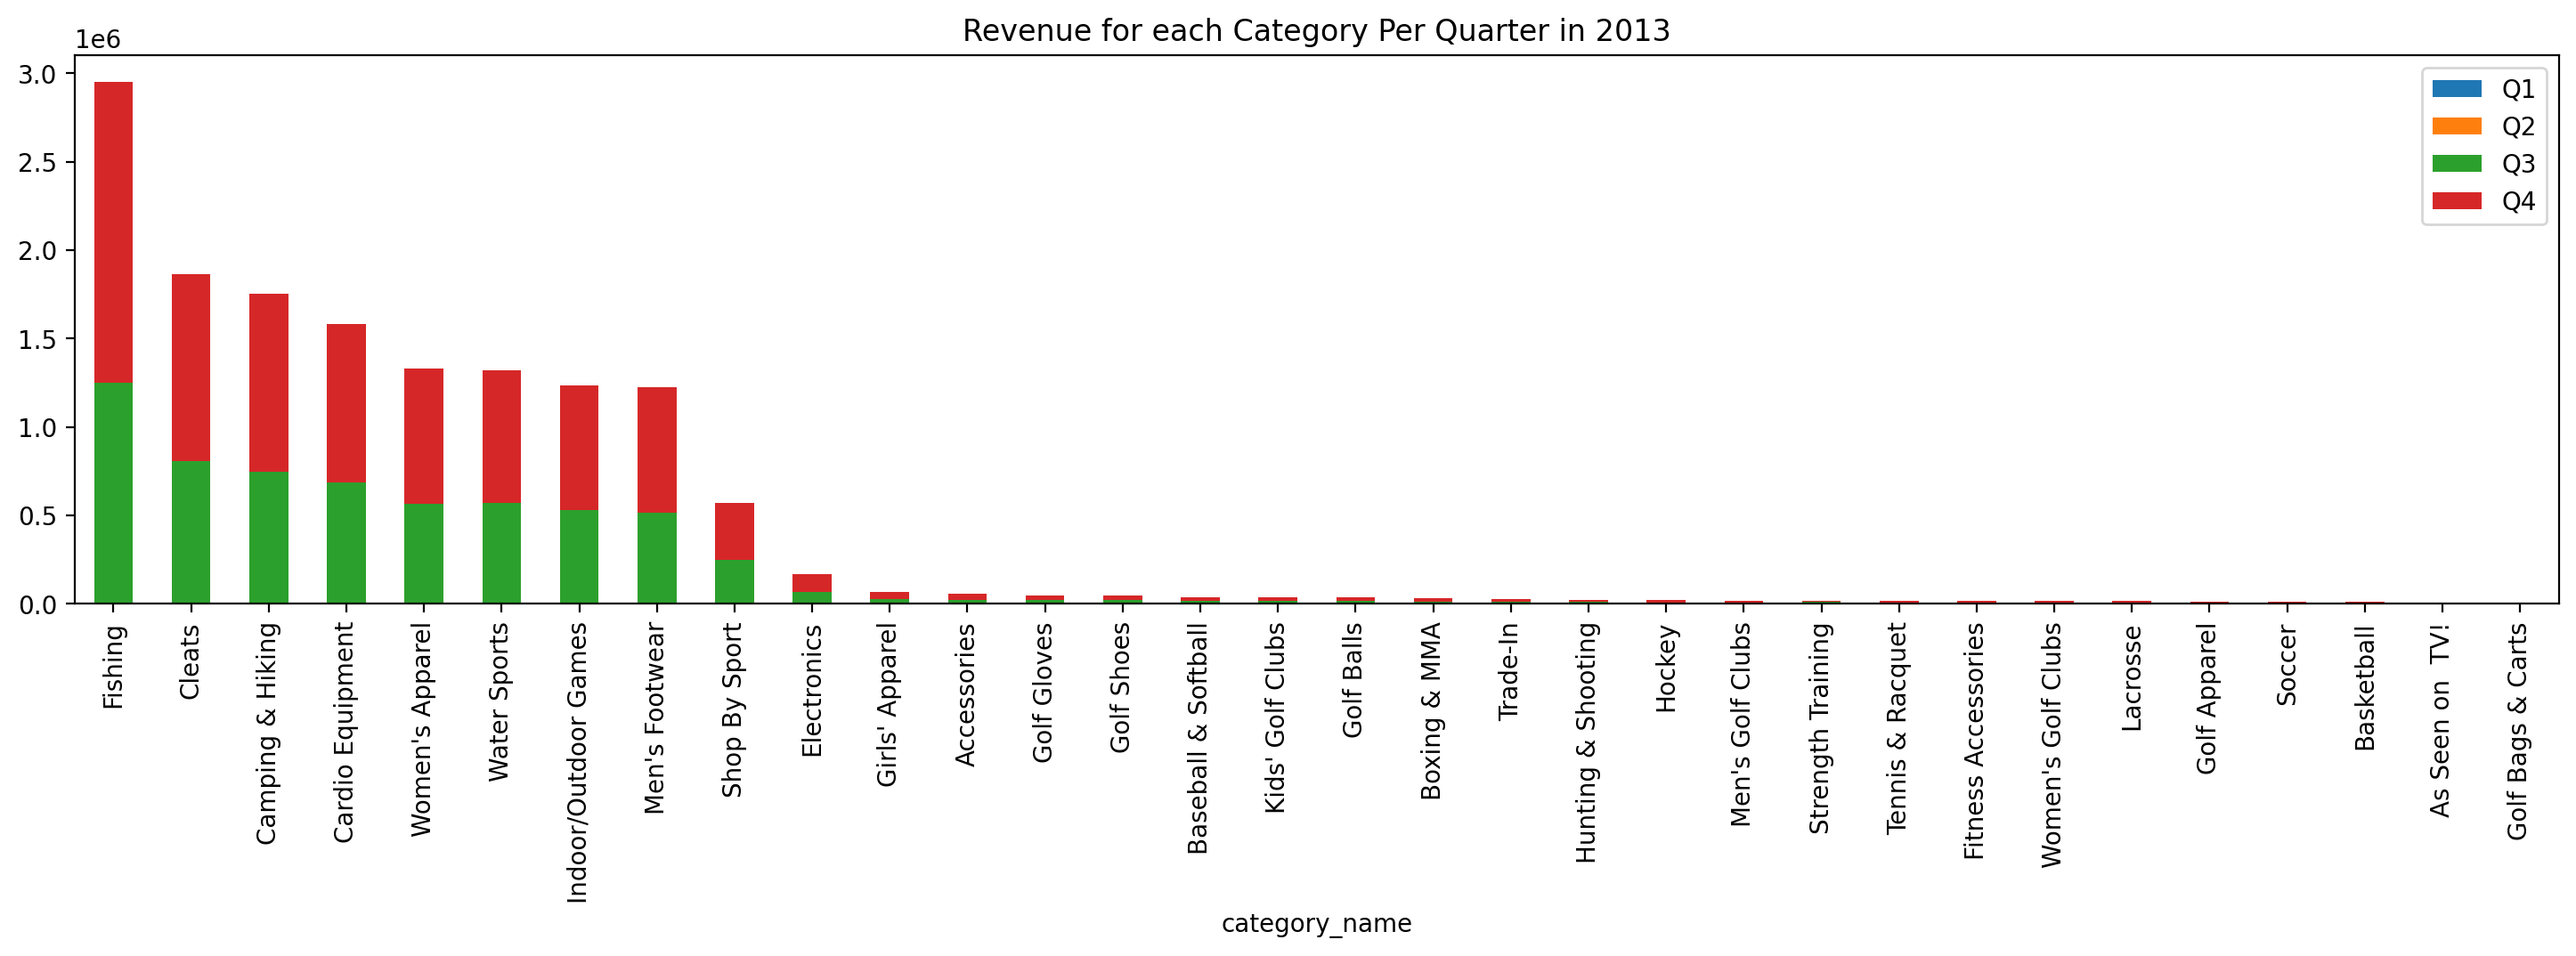

In [0]:
revenue_cat_qtr_df_pandas.drop(['order_year', 'total_sales'], axis=1).plot.bar(x='category_name', stacked=True, title='Revenue for each Category Per Quarter in 2013')

In [0]:
##### For 2014
### Converting to Pandas DataFrame for visualization

In [0]:
revenue_cat_qtr_df_pandas = revenue_cat_qtr_df.filter(col('order_year') == '2014').cache().toPandas()

In [0]:
revenue_cat_qtr_df_pandas.head()

,category_name,order_year,Q1,Q2,Q3,Q4,total_sales
0,Fishing,2014,1673916.35,1594720.30,415179.25,NaN,3683815.90
1,Cleats,2014,1080480.24,1027808.94,270734.96,NaN,2379024.14
2,Camping & Hiking,2014,981834.58,935637.65,273281.79,NaN,2190754.02
3,Cardio Equipment,2014,855664.98,873333.24,223277.91,NaN,1952276.13
4,Women's Apparel,2014,756700.00,728450.00,196000.00,NaN,1681150.00


<AxesSubplot:title={'center':'Revenue for each Category Per Quarter in 2013'}, xlabel='category_name'>

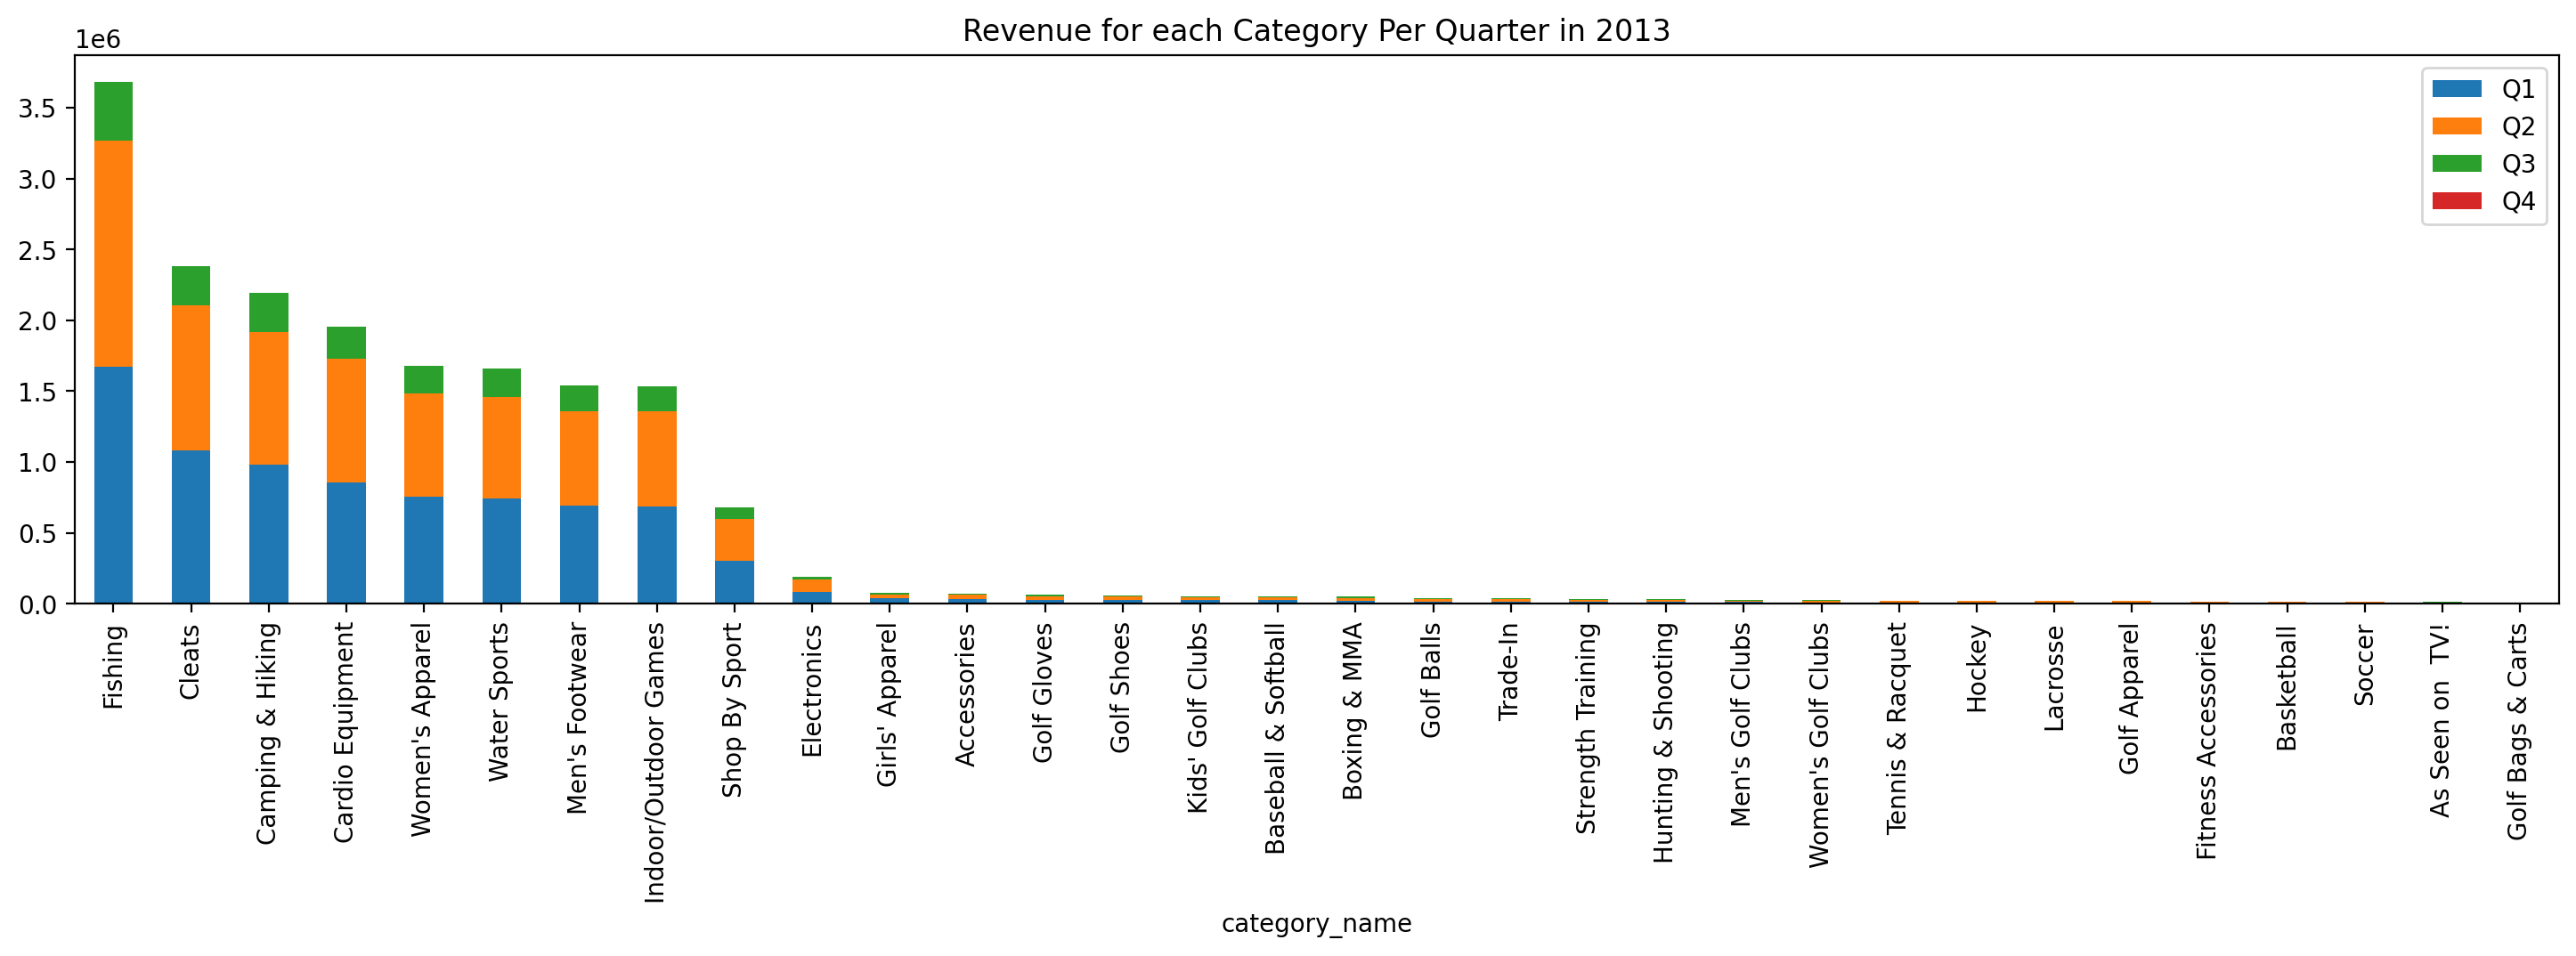

In [0]:
revenue_cat_qtr_df_pandas.drop(['order_year', 'total_sales'], axis=1).plot.bar(x='category_name', stacked=True, title='Revenue for each Category Per Quarter in 2013')

In [0]:
revenue_cat_qtr_df.unpersist()

DataFrame[category_name: string, order_year: int, Q1: double, Q2: double, Q3: double, Q4: double, total_sales: double]

### 4.11 Number of Orders By Status

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT order_status,count(1) as total
            FROM orders 
            GROUP BY order_status
          ''').show()

+---------------+-----+
|   order_status|total|
+---------------+-----+
|PENDING_PAYMENT|15030|
|       COMPLETE|22899|
|        ON_HOLD| 3798|
| PAYMENT_REVIEW|  729|
|     PROCESSING| 8275|
|         CLOSED| 7556|
|SUSPECTED_FRAUD| 1558|
|        PENDING| 7610|
|       CANCELED| 1428|
+---------------+-----+



##### DF API

In [0]:
df = order_df.groupBy('order_status').count().withColumnRenamed('count','total')
df.cache()

DataFrame[order_status: string, total: bigint]

In [0]:
df.show()

+---------------+-----+
|   order_status|total|
+---------------+-----+
|PENDING_PAYMENT|15030|
|       COMPLETE|22899|
|        ON_HOLD| 3798|
| PAYMENT_REVIEW|  729|
|     PROCESSING| 8275|
|         CLOSED| 7556|
|SUSPECTED_FRAUD| 1558|
|        PENDING| 7610|
|       CANCELED| 1428|
+---------------+-----+



In [0]:
pandas_df = df.toPandas()

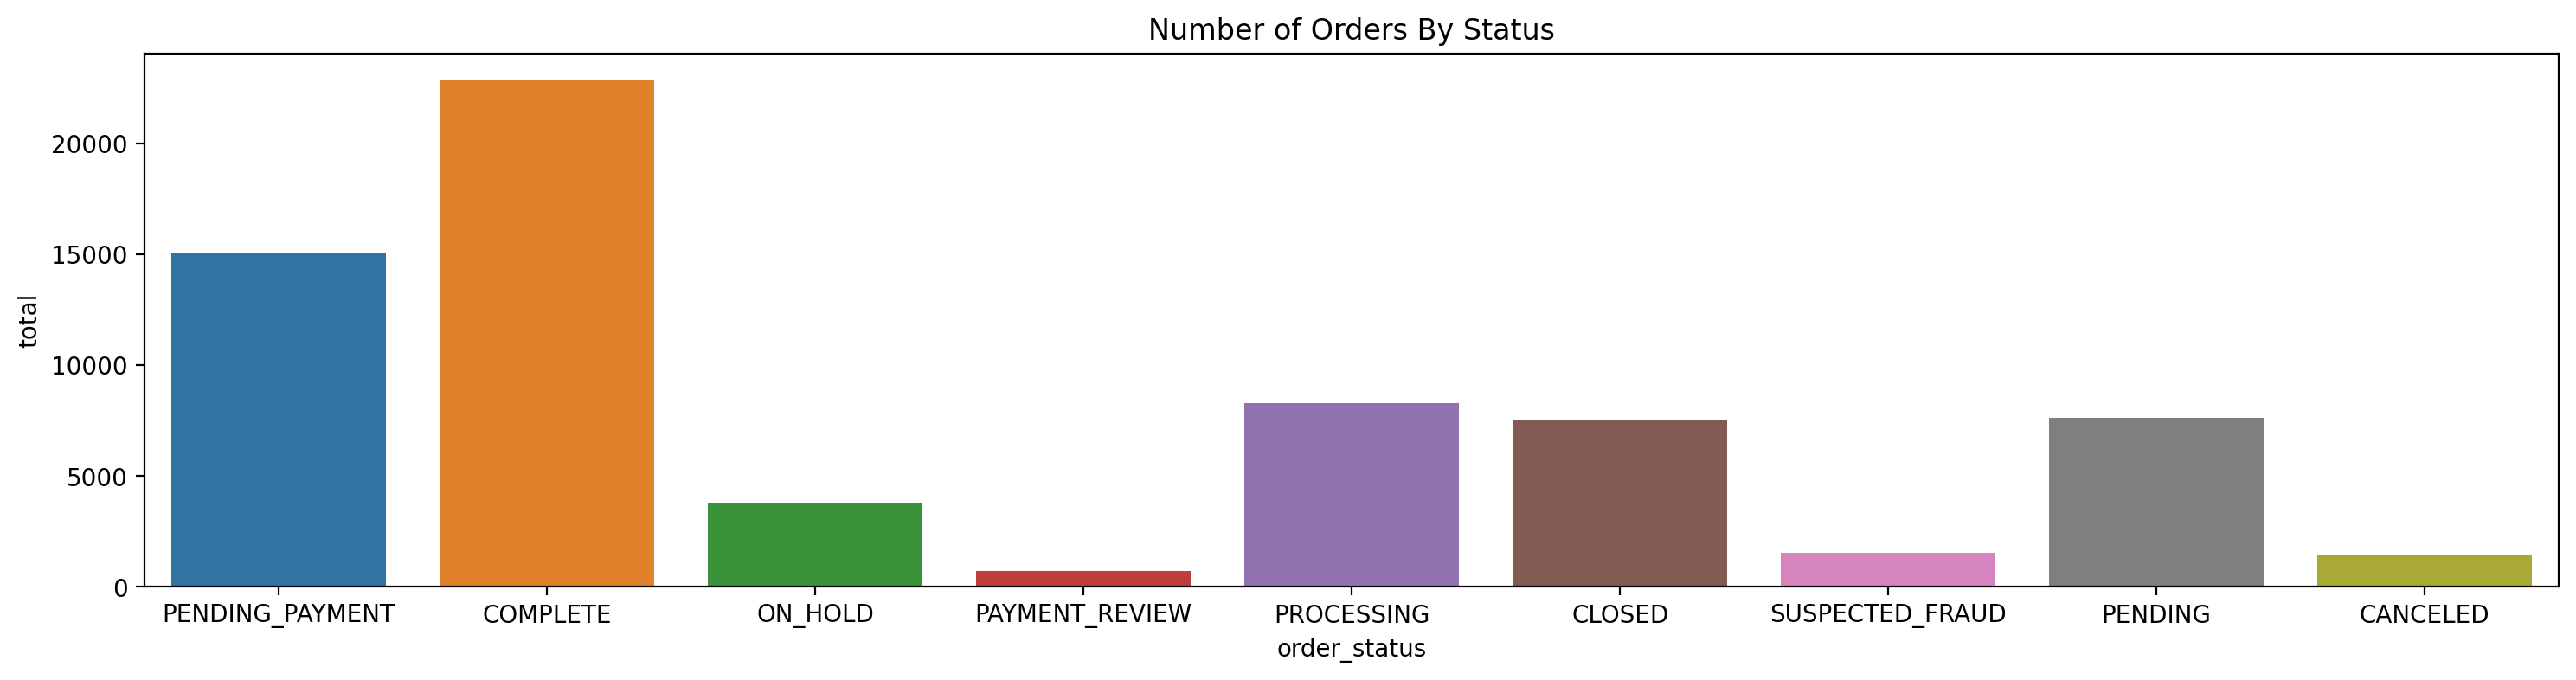

In [0]:
o = sns.barplot(x='order_status', y='total', data=pandas_df)
o.set_title('Number of Orders By Status');

In [0]:
df.unpersist()

DataFrame[order_status: string, total: bigint]

### 4.12: Number of Orders By Order Date and Order Status:

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT order_date,order_status,count(1) as total
            FROM orders 
            GROUP BY order_date,order_status
            ORDER BY order_date
''').show(truncate = False)

+---------------------+---------------+-----+
|order_date           |order_status   |total|
+---------------------+---------------+-----+
|2013-07-25 00:00:00.0|PENDING_PAYMENT|41   |
|2013-07-25 00:00:00.0|ON_HOLD        |5    |
|2013-07-25 00:00:00.0|PROCESSING     |16   |
|2013-07-25 00:00:00.0|COMPLETE       |42   |
|2013-07-25 00:00:00.0|PENDING        |13   |
|2013-07-25 00:00:00.0|CANCELED       |1    |
|2013-07-25 00:00:00.0|CLOSED         |20   |
|2013-07-25 00:00:00.0|SUSPECTED_FRAUD|2    |
|2013-07-25 00:00:00.0|PAYMENT_REVIEW |3    |
|2013-07-26 00:00:00.0|COMPLETE       |87   |
|2013-07-26 00:00:00.0|SUSPECTED_FRAUD|5    |
|2013-07-26 00:00:00.0|ON_HOLD        |19   |
|2013-07-26 00:00:00.0|PENDING_PAYMENT|59   |
|2013-07-26 00:00:00.0|CANCELED       |3    |
|2013-07-26 00:00:00.0|CLOSED         |29   |
|2013-07-26 00:00:00.0|PROCESSING     |30   |
|2013-07-26 00:00:00.0|PENDING        |31   |
|2013-07-26 00:00:00.0|PAYMENT_REVIEW |6    |
|2013-07-27 00:00:00.0|PROCESSING 

##### DF API

In [0]:
order_df.groupBy(['order_date','order_status']).count().withColumnRenamed('count', 'total').orderBy('order_date').show(truncate=False)

+---------------------+---------------+-----+
|order_date           |order_status   |total|
+---------------------+---------------+-----+
|2013-07-25 00:00:00.0|PENDING_PAYMENT|41   |
|2013-07-25 00:00:00.0|ON_HOLD        |5    |
|2013-07-25 00:00:00.0|PROCESSING     |16   |
|2013-07-25 00:00:00.0|COMPLETE       |42   |
|2013-07-25 00:00:00.0|PENDING        |13   |
|2013-07-25 00:00:00.0|CANCELED       |1    |
|2013-07-25 00:00:00.0|CLOSED         |20   |
|2013-07-25 00:00:00.0|SUSPECTED_FRAUD|2    |
|2013-07-25 00:00:00.0|PAYMENT_REVIEW |3    |
|2013-07-26 00:00:00.0|COMPLETE       |87   |
|2013-07-26 00:00:00.0|SUSPECTED_FRAUD|5    |
|2013-07-26 00:00:00.0|ON_HOLD        |19   |
|2013-07-26 00:00:00.0|PENDING_PAYMENT|59   |
|2013-07-26 00:00:00.0|CANCELED       |3    |
|2013-07-26 00:00:00.0|CLOSED         |29   |
|2013-07-26 00:00:00.0|PROCESSING     |30   |
|2013-07-26 00:00:00.0|PENDING        |31   |
|2013-07-26 00:00:00.0|PAYMENT_REVIEW |6    |
|2013-07-27 00:00:00.0|PROCESSING 

### 4.13: Get CANCELED orders with amount greater than $1500

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT t.* FROM (
                    SELECT o.order_id,o.order_date,o.order_customer_id,o.order_customer_id, o.order_status, SUM(oi.order_item_subtotal) as order_total
                    FROM orders o INNER JOIN order_items oi ON o.order_id = oi.order_item_order_id
                    WHERE o.order_status = 'CANCELED'
                    GROUP BY o.order_id,o.order_date,o.order_customer_id, o.order_status
                    ) t
            WHERE t.order_total > 1500
            ORDER BY t.order_id
''').show(truncate=False)

+--------+---------------------+-----------------+-----------------+------------+------------------+
|order_id|order_date           |order_customer_id|order_customer_id|order_status|order_total       |
+--------+---------------------+-----------------+-----------------+------------+------------------+
|12032   |2013-10-06 00:00:00.0|6249             |6249             |CANCELED    |1599.9000396728516|
|13298   |2013-10-14 00:00:00.0|10549            |10549            |CANCELED    |1549.7500305175781|
|13549   |2013-10-16 00:00:00.0|4549             |4549             |CANCELED    |1599.8800354003906|
|23425   |2013-12-17 00:00:00.0|9967             |9967             |CANCELED    |1759.9000244140625|
|38689   |2014-03-20 00:00:00.0|5485             |5485             |CANCELED    |1627.8500137329102|
|46899   |2014-05-11 00:00:00.0|10252            |10252            |CANCELED    |1699.8600463867188|
|56555   |2014-07-18 00:00:00.0|4489             |4489             |CANCELED    |1629.88005

##### DF API

In [0]:
cancelled_orders = (order_df.filter(col('order_status') == 'CANCELED')
                            .join(order_item_df, order_df.order_id == order_item_df.order_item_order_id, how='inner')
                            .groupBy(order_df.order_id, order_df.order_date, order_df.order_customer_id, order_df.order_status)
                            .agg(F.sum('order_item_subtotal').alias('total'))
                            .filter(col('total') > 1500)
                            .orderBy('order_id')
                   )

cancelled_orders.cache()

DataFrame[order_id: int, order_date: string, order_customer_id: int, order_status: string, total: double]

In [0]:
cancelled_orders.show(truncate=False)

+--------+---------------------+-----------------+------------+------------------+
|order_id|order_date           |order_customer_id|order_status|total             |
+--------+---------------------+-----------------+------------+------------------+
|12032   |2013-10-06 00:00:00.0|6249             |CANCELED    |1599.9000396728516|
|13298   |2013-10-14 00:00:00.0|10549            |CANCELED    |1549.7500305175781|
|13549   |2013-10-16 00:00:00.0|4549             |CANCELED    |1599.8800354003906|
|23425   |2013-12-17 00:00:00.0|9967             |CANCELED    |1759.9000244140625|
|38689   |2014-03-20 00:00:00.0|5485             |CANCELED    |1627.8500137329102|
|46899   |2014-05-11 00:00:00.0|10252            |CANCELED    |1699.8600463867188|
|56555   |2014-07-18 00:00:00.0|4489             |CANCELED    |1629.8800506591797|
|58966   |2013-09-09 00:00:00.0|5175             |CANCELED    |1529.8800354003906|
|68816   |2014-03-26 00:00:00.0|8769             |CANCELED    |2329.939987182617 |
+---

###### Lets visualize by making histogram

[Text(0.5, 0, 'Amount'), Text(0, 0.5, 'Count')]

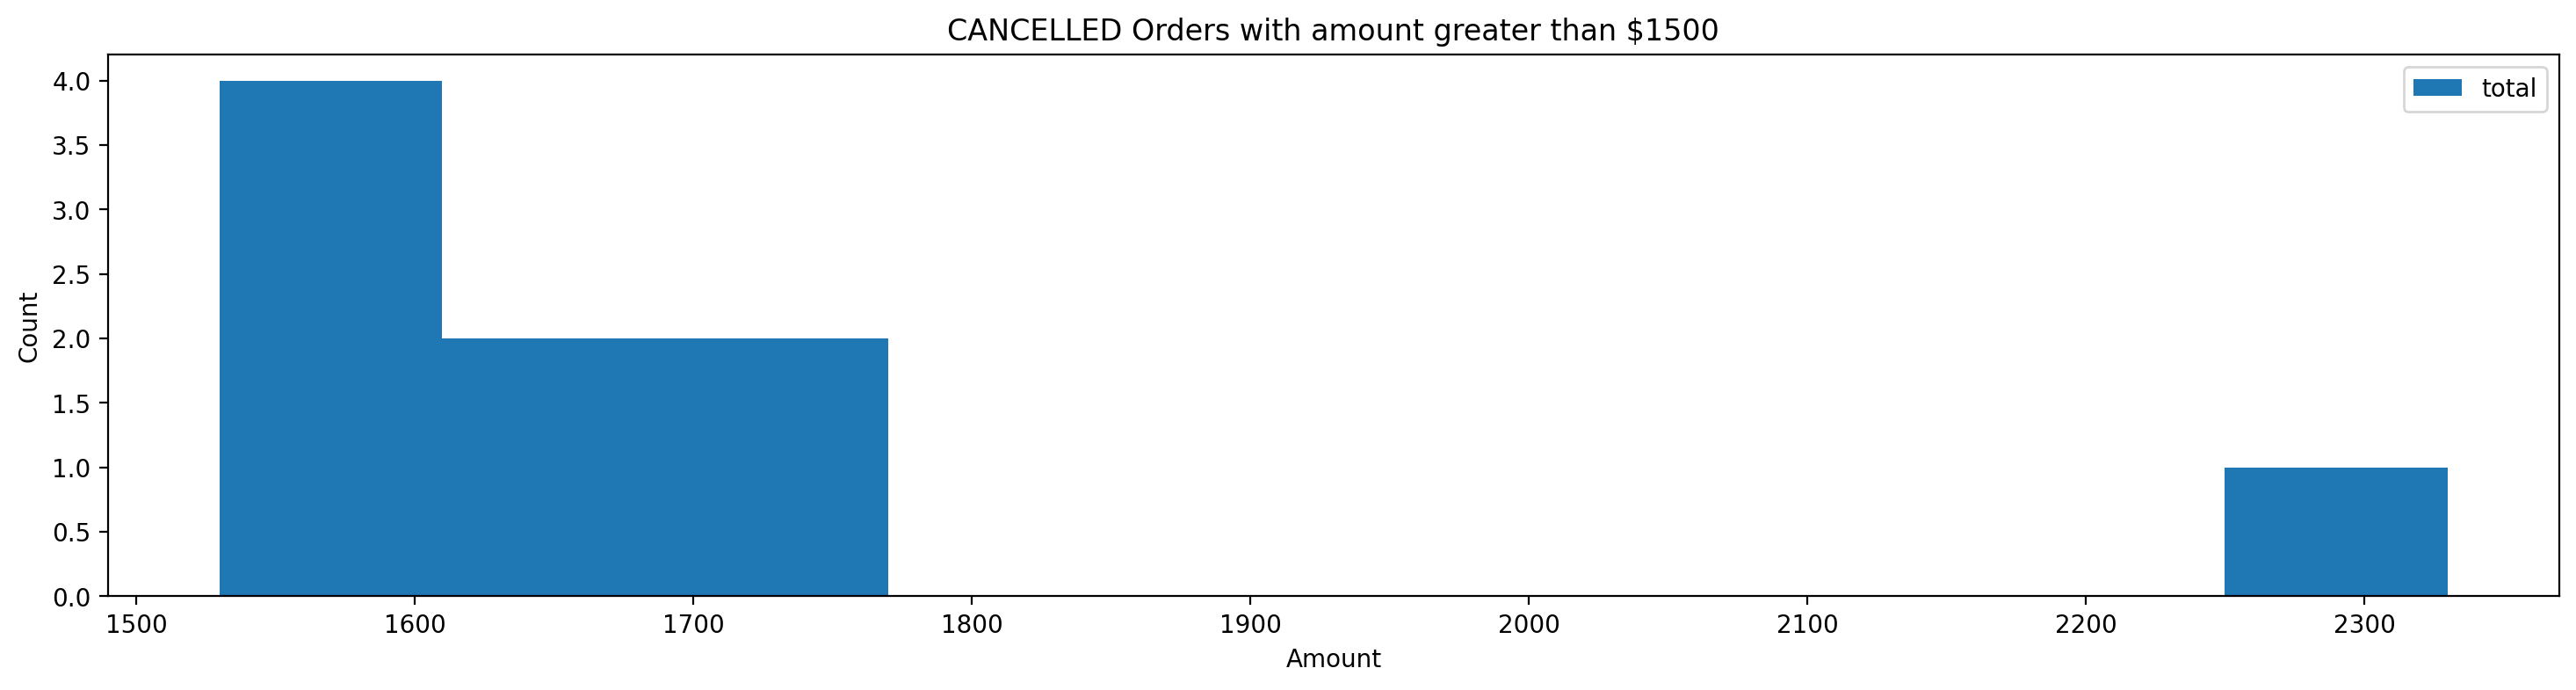

In [0]:
cancelled = cancelled_orders.toPandas().plot.hist(y='total', title='CANCELLED Orders with amount greater than $1500')
cancelled.set(xlabel='Amount', ylabel='Count')

In [0]:
cancelled_orders.unpersist()

DataFrame[order_id: int, order_date: string, order_customer_id: int, order_status: string, total: double]

### 4.14: Sort Products By Category and Price

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT p.product_id, p.product_category_id, p.product_name, p.price
            FROM products p
            ORDER BY p.product_category_id ASC,p.price DESC
''').show(truncate=False)

+----------+-------------------+---------------------------------------------+------+
|product_id|product_category_id|product_name                                 |price |
+----------+-------------------+---------------------------------------------+------+
|16        |2                  |Riddell Youth 360 Custom Football Helmet     |299.99|
|11        |2                  |Fitness Gear 300 lb Olympic Weight Set       |209.99|
|5         |2                  |Riddell Youth Revolution Speed Custom Footbal|199.99|
|14        |2                  |Quik Shade Summit SX170 10 FT. x 10 FT. Canop|199.99|
|12        |2                  |Under Armour Men's Highlight MC Alter Ego Fla|139.99|
|23        |2                  |Under Armour Men's Highlight MC Alter Ego Hul|139.99|
|6         |2                  |Jordan Men's VI Retro TD Football Cleat      |134.99|
|2         |2                  |Under Armour Men's Highlight MC Football Clea|129.99|
|8         |2                  |Nike Men's Vapor Carbo

##### DF API

In [0]:
(product_df.select(['product_id','product_category_id','product_name','price'])
           .orderBy(['product_category_id','price'], ascending=[1,0]).show(truncate=False)
)

+----------+-------------------+---------------------------------------------+------+
|product_id|product_category_id|product_name                                 |price |
+----------+-------------------+---------------------------------------------+------+
|16        |2                  |Riddell Youth 360 Custom Football Helmet     |299.99|
|11        |2                  |Fitness Gear 300 lb Olympic Weight Set       |209.99|
|5         |2                  |Riddell Youth Revolution Speed Custom Footbal|199.99|
|14        |2                  |Quik Shade Summit SX170 10 FT. x 10 FT. Canop|199.99|
|12        |2                  |Under Armour Men's Highlight MC Alter Ego Fla|139.99|
|23        |2                  |Under Armour Men's Highlight MC Alter Ego Hul|139.99|
|6         |2                  |Jordan Men's VI Retro TD Football Cleat      |134.99|
|2         |2                  |Under Armour Men's Highlight MC Football Clea|129.99|
|8         |2                  |Nike Men's Vapor Carbo

### 4.15: Sort Products By Price Within Each Category

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT p.product_id,p.product_category_id,p.product_name,p.price
            FROM products p
            DISTRIBUTE BY p.product_category_id
            SORT BY p.price DESC
''').show(truncate=False)

+----------+-------------------+------------------------------------------------+-------+
|product_id|product_category_id|product_name                                    |price  |
+----------+-------------------+------------------------------------------------+-------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99|
|496       |22                 |SOLE F85 Treadmill                              |1799.99|
|66        |4                  |SOLE F85 Treadmill                              |1799.99|
|199       |10                 |SOLE F85 Treadmill                              |1799.99|
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99|
|488       |22                 |SOLE E25 Elliptical                             |999.99 |
|60        |4                  |SOLE E25 Elliptical                             |999.99 |
|197       |10                 |SOLE E25 Elliptical                             |999.99 |
|694      

##### DF API

In [0]:
(product_df.repartition('product_category_id')
           .sortWithinPartitions('price', ascending=0)
           .select(['product_id', 'product_category_id', 'product_name', 'price'])
           .show(truncate=False))

+----------+-------------------+------------------------------------------------+-------+
|product_id|product_category_id|product_name                                    |price  |
+----------+-------------------+------------------------------------------------+-------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99|
|496       |22                 |SOLE F85 Treadmill                              |1799.99|
|66        |4                  |SOLE F85 Treadmill                              |1799.99|
|199       |10                 |SOLE F85 Treadmill                              |1799.99|
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99|
|488       |22                 |SOLE E25 Elliptical                             |999.99 |
|60        |4                  |SOLE E25 Elliptical                             |999.99 |
|197       |10                 |SOLE E25 Elliptical                             |999.99 |
|694      

### 4.16: TopMost 10 Products overall sorted by Price Highest to Lowest

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT product_id, product_category_id, product_name, price
            FROM products
            ORDER BY price DESC
            LIMIT 10
''').show(truncate=False)

+----------+-------------------+------------------------------------------------+-------+
|product_id|product_category_id|product_name                                    |price  |
+----------+-------------------+------------------------------------------------+-------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99|
|66        |4                  |SOLE F85 Treadmill                              |1799.99|
|199       |10                 |SOLE F85 Treadmill                              |1799.99|
|496       |22                 |SOLE F85 Treadmill                              |1799.99|
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99|
|60        |4                  |SOLE E25 Elliptical                             |999.99 |
|197       |10                 |SOLE E25 Elliptical                             |999.99 |
|488       |22                 |SOLE E25 Elliptical                             |999.99 |
|694      

##### DF API

In [0]:
(product_df.select(['product_id', 'product_category_id', 'product_name', 'price'])
           .orderBy('price',ascending=False)
           .limit(10)
           .show(truncate=False)
)        


+----------+-------------------+------------------------------------------------+-------+
|product_id|product_category_id|product_name                                    |price  |
+----------+-------------------+------------------------------------------------+-------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99|
|66        |4                  |SOLE F85 Treadmill                              |1799.99|
|199       |10                 |SOLE F85 Treadmill                              |1799.99|
|496       |22                 |SOLE F85 Treadmill                              |1799.99|
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99|
|60        |4                  |SOLE E25 Elliptical                             |999.99 |
|197       |10                 |SOLE E25 Elliptical                             |999.99 |
|488       |22                 |SOLE E25 Elliptical                             |999.99 |
|694      

### 4.17: TopMost 10 Products in each Category where the Products are Sorted by Price Highest to Lowest

##### SPARK SQL

In [0]:
spark.sql('''
            SELECT product_category_id, product_id, product_name, price, row_num
            FROM (
                    SELECT q.*, row_number() OVER( PARTITION BY q.product_category_id ORDER BY q.price DESC) AS row_num
                    FROM products q           
                )
            WHERE row_num <= 10
            ORDER BY product_category_id,row_num

''').show(truncate=False)

+-------------------+----------+---------------------------------------------+------+-------+
|product_category_id|product_id|product_name                                 |price |row_num|
+-------------------+----------+---------------------------------------------+------+-------+
|2                  |16        |Riddell Youth 360 Custom Football Helmet     |299.99|1      |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set       |209.99|2      |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal|199.99|3      |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop|199.99|4      |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla|139.99|5      |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul|139.99|6      |
|2                  |6         |Jordan Men's VI Retro TD Football Cleat      |134.99|7      |
|2                  |2         |Under Armour Men's Highlight

##### DF API

In [0]:
windowPrice = Window.partitionBy(product_df['product_category_id']).orderBy(product_df['price'].desc())

In [0]:
(product_df.select('product_category_id', 'product_id', 'product_name', 'price',F.row_number().over(windowPrice).alias('row_num'))
           .filter(col('row_num') <= 10)
           .orderBy('product_category_id', 'row_num')
           .show(truncate=False)
)

+-------------------+----------+---------------------------------------------+------+-------+
|product_category_id|product_id|product_name                                 |price |row_num|
+-------------------+----------+---------------------------------------------+------+-------+
|2                  |16        |Riddell Youth 360 Custom Football Helmet     |299.99|1      |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set       |209.99|2      |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal|199.99|3      |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop|199.99|4      |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla|139.99|5      |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul|139.99|6      |
|2                  |6         |Jordan Men's VI Retro TD Football Cleat      |134.99|7      |
|2                  |2         |Under Armour Men's Highlight

In [0]:
spark.stop()